In [ ]:
import numpy as np
import model.train_schedule
import model.model_defination
import model
from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [ ]:
net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)

In [ ]:
def normoalizeArray(array: np.ndarray, newmin, newmax) -> np.ndarray:
    '''
    将array中的最大值变为max，最小值变为min，其他的数值按照平均原则计算。
    Parameters
    ----------
    array:需要改变的的数组
    newmin:最小值
    newmax:最大值

    Returns
    -------
    值改变后的数组
    '''
    originMax = array.max()
    originMin = array.min()
    difference = originMax - originMin
    newArray = (array - originMin) / difference * (newmax - newmin) + newmin
    return newArray


def arrayToImg(arr: np.ndarray) -> np.ndarray:
    '''将数组的值改为[0,255]范围内

    Parameters
    ----------
    arr : np.ndarray
        被改变的数组

    Returns
    -------
    np.ndarray
        修改后的数组
    '''
    return normoalizeArray(arr.astype('np.uint8'), 0, 255)


def saveImg(arr: np.ndarray, filename: str):
    '''保存图片

    Parameters
    ----------
    arr : np.ndarray
        被保存的数组
    filename : str
        图片的文件名
    '''
    Image.fromarray(arrayToImg(arr)).save(filename)


def showImg(arr: np.ndarray):
    '''将数组作为图片展示

    Parameters
    ----------
    arr : np.ndarray
        需要展示的数组
    '''
    Image.fromarray(arrayToImg(arr)).show()


def grayImageToRGB(arr: np.ndarray) -> np.ndarray:
    '''将灰度图像的复制三份，成为RGB图像
    
    Parameters
    ----------
    arr : np.ndarray
        灰度图像，形状为HW或者NHW

    Returns
    -------
    np.ndarray
        RGB三通道图像，形状为HWC或者NHWC

    Raises
    ------
    ValueError
        图像的维度必须为2，否则会引发ValueError
    '''
    if arr.ndim == 3:
        return np.concatenate((np.expand_dims(arr, 3), np.expand_dims(
            arr, 3), np.expand_dims(arr, 3)),
                              axis=3)
    elif arr.ndim == 2:
        return np.concatenate((np.expand_dims(arr, 2), np.expand_dims(
            arr, 2), np.expand_dims(arr, 2)),
                              axis=2)
    else:
        raise ValueError(
            'Dimensions of input array must be 3(NHW) or 2(HW),got {}'.format(
                arr.ndim))

交互式GraphCut算法

In [ ]:
# 利用OpenCV实现交互式的Graph Cut算法
# 来自https://blog.csdn.net/youcans/article/details/124723416
import cv2
import numpy as np
from matplotlib import pyplot as plt

drawing = False
mode = False


class GraphCutXupt:
    def __init__(self, t_img):
        self.img = t_img
        self.img_raw = img.copy()
        self.img_width = img.shape[0]
        self.img_height = img.shape[1]
        self.scale_size = 640 * self.img_width // self.img_height
        if self.img_width > 640:
            self.img = cv2.resize(self.img, (640, self.scale_size),
                                  interpolation=cv2.INTER_AREA)
        self.img_show = self.img.copy()
        self.img_gc = self.img.copy()
        self.img_gc = cv2.GaussianBlur(self.img_gc, (3, 3), 0)
        self.lb_up = False
        self.rb_up = False
        self.lb_down = False
        self.rb_down = False
        self.mask = np.full(self.img.shape[:2], 2, dtype=np.uint8)
        self.firt_choose = True


# 鼠标的回调函数
def mouse_event2(event, x, y, flags, param):
    global drawing, last_point, start_point
    # 左键按下：开始画图
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_point = (x, y)
        start_point = last_point
        param.lb_down = True
        print('mouse lb down')
    elif event == cv2.EVENT_RBUTTONDOWN:
        drawing = True
        last_point = (x, y)
        start_point = last_point
        param.rb_down = True
        print('mouse rb down')
    # 鼠标移动，画图
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            if param.lb_down:
                cv2.line(param.img_show, last_point, (x, y), (0, 0, 255), 2,
                         -1)
                cv2.rectangle(param.mask, last_point, (x, y), 1, -1, 4)
            else:
                cv2.line(param.img_show, last_point, (x, y), (255, 0, 0), 2,
                         -1)
                cv2.rectangle(param.mask, last_point, (x, y), 0, -1, 4)
            last_point = (x, y)
    # 左键释放：结束画图
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        param.lb_up = True
        param.lb_down = False
        cv2.line(param.img_show, last_point, (x, y), (0, 0, 255), 2, -1)
        if param.firt_choose:
            param.firt_choose = False
        cv2.rectangle(param.mask, last_point, (x, y), 1, -1, 4)
        print('mouse lb up')
    elif event == cv2.EVENT_RBUTTONUP:
        drawing = False
        param.rb_up = True
        param.rb_down = False
        cv2.line(param.img_show, last_point, (x, y), (255, 0, 0), 2, -1)
        if param.firt_choose:
            param.firt_choose = False
            param.mask = np.full(param.img.shape[:2], 3, dtype=np.uint8)
        cv2.rectangle(param.mask, last_point, (x, y), 0, -1, 4)
        print('mouse rb up')


if __name__ == '__main__':
    img = cv2.imread(
        "MiddleData/original/20130820_092405_lasc2rdf_aia193rdf.png",
        flags=1)  # 读取彩色图像(Youcans)
    g_img = GraphCutXupt(img)

    cv2.namedWindow('image')
    # 定义鼠标的回调函数
    cv2.setMouseCallback('image', mouse_event2, g_img)
    while (True):
        cv2.imshow('image', g_img.img_show)
        if g_img.lb_up or g_img.rb_up:
            g_img.lb_up = False
            g_img.rb_up = False
            bgdModel = np.zeros((1, 65), np.float64)
            fgdModel = np.zeros((1, 65), np.float64)
            rect = (1, 1, g_img.img.shape[1], g_img.img.shape[0])
            print(g_img.mask)
            mask = g_img.mask
            g_img.img_gc = g_img.img.copy()
            cv2.grabCut(g_img.img_gc, mask, rect, bgdModel, fgdModel, 5,
                        cv2.GC_INIT_WITH_MASK)
            mask2 = np.where((mask == 2) | (mask == 0), 0,
                             1).astype('uint8')  # 0和2做背景
            g_img.img_gc = g_img.img_gc * mask2[:, :,
                                                np.newaxis]  # 使用蒙板来获取前景区域
            cv2.imshow('youcans', g_img.img_gc)
        # 按下ESC键退出
        if cv2.waitKey(20) == 27:
            break

    plt.figure(figsize=(10, 7))
    plt.subplot(221), plt.axis('off'), plt.title("xupt")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
    plt.subplot(222), plt.axis('off'), plt.title("mask")
    plt.imshow(mask, 'gray')
    plt.subplot(223), plt.axis('off'), plt.title("mask2")
    plt.imshow(mask2, 'gray')
    plt.subplot(224), plt.axis('off'), plt.title("Grab Cut")
    plt.imshow(cv2.cvtColor(g_img.img_gc, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()


使用前景选框的GrabCut算法

In [ ]:
# 利用OpenCV实现GrabCut算法(前景选框)
# 来自https://blog.csdn.net/youcans/article/details/124744467
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread("/home/lin/Pictures/R-C.jpg", flags=1)  # 读取彩色图像(BGR)
mask = np.zeros(image.shape[:2], dtype="uint8")

# 定义矩形框，框选目标前景
# rect = (118, 125, 220, 245)  # 直接设置矩形的位置参数，也可以鼠标框选 ROI
print("Select a ROI and then press SPACE or ENTER button!\n")
roi = cv2.selectROI(image, showCrosshair=True, fromCenter=False)
xmin, ymin, w, h = roi  # 矩形裁剪区域 (ymin:ymin+h, xmin:xmin+w) 的位置参数
rect = (xmin, ymin, w, h)  # 边界框矩形的坐标和尺寸
imgROI = np.zeros_like(image)  # 创建与 image 相同形状的黑色图像
imgROI[ymin:ymin + h, xmin:xmin + w] = image[ymin:ymin + h,
                                             xmin:xmin + w].copy()
print(xmin, ymin, w, h)

fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(mask, bgModel, fgModel) = cv2.grabCut(image,
                                       mask,
                                       rect,
                                       bgModel,
                                       fgModel,
                                       iter,
                                       mode=cv2.GC_INIT_WITH_RECT)  # 框选前景分割模式

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 7))
plt.subplot(231), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
plt.subplot(232), plt.axis('off'), plt.title("Bounding box")
plt.imshow(cv2.cvtColor(imgROI, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
plt.subplot(233), plt.axis('off'), plt.title(
    "Mask for definite background(White area)")
maskBGD = (mask == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')  # definite background
plt.subplot(234), plt.axis('off'), plt.title(
    "Mask for probable background(white area)")
maskPBGD = (mask == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')  # probable background
plt.subplot(235), plt.axis('off'), plt.title(
    "GrabCut Mask(White for Foreground,Black for Background)")
# maskGrabCut = np.where((mask==cv2.GC_BGD) | (mask==cv2.GC_PR_BGD), 0, 1)
plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut
plt.subplot(236), plt.axis('off'), plt.title("GrabCut Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output
plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(maskImg, cmap='gray')


使用掩膜图像的GrabCut算法

In [ ]:
# 利用OpenCV实现GrabCut算法（掩模图像）
# 来自https://blog.csdn.net/youcans/article/details/124744517
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
# cv::GrabCutClasses {
#   cv::GC_BGD = 0,
#   cv::GC_FGD = 1,
#   cv::GC_PR_BGD = 2,
#   cv::GC_PR_FGD = 3
# }
image = cv2.imread(
    r"C:\Programing\MiddleData/original/20130820_102405_lasc2rdf_aia193rdf.png",
    flags=1)  # 读取彩色图像(BGR)
# *对于CME灰度图像，三个通道的值完全相同
maskImg = cv2.imread(r"C:\Programing\MiddleData/cropresult/crop9.png",
                     flags=0)[:, 512:]  # 读取掩模图像(xupt) TODO need modification

# 生成掩模图像 mask，大于 0 的像素设为可能前景
mask = np.zeros(image.shape[:2], dtype="uint8")
mask[maskImg > 0] = cv2.GC_PR_FGD
mask[maskImg == 0] = cv2.GC_BGD
# print(mask.shape, maskInv.shape)
# apply GrabCut using the the mask segmentation method
fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(mask, bgModel, fgModel) = cv2.grabCut(image,
                                       mask,
                                       None,
                                       bgModel,
                                       fgModel,
                                       iter,
                                       mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
# //原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
# //否则显示的区域就成了背景，所以进行修改
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 6))
plt.subplot(231), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)
plt.subplot(232), plt.axis('off'), plt.title("Mask image")
plt.imshow(maskImg, 'gray')  # definite background
plt.subplot(233), plt.axis('off'), plt.title("GrabCut mask")
plt.imshow(mask, 'gray')
plt.subplot(234), plt.axis('off'), plt.title("Mask for definite background")
maskBGD = (mask == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')  # definite background
plt.subplot(235), plt.axis('off'), plt.title("Mask for probable background")
maskPBGD = (mask == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')  # probable background
# plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
# plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut
plt.subplot(236), plt.axis('off'), plt.title("Youcans Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output
plt.tight_layout()
plt.show()


对掩膜图像的GrabCut进行了自行修改

In [ ]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
# cv::GrabCutClasses {
#   cv::GC_BGD = 0,
#   cv::GC_FGD = 1,
#   cv::GC_PR_BGD = 2,
#   cv::GC_PR_FGD = 3
# }
image = cv2.imread(
    r"C:\Programing\MiddleData/original/20130820_102405_lasc2rdf_aia193rdf.png",
    flags=1)  # 读取彩色图像(BGR)
# *对于CME灰度图像，三个通道的值完全相同
maskImg = cv2.imread(r"C:\Programing\MiddleData/cropresult/crop9.png",
                     flags=0)[:, 512:]  # 读取掩模图像(xupt) TODO need modification

# 生成掩模图像 mask，大于 0 的像素设为可能前景
mask = np.zeros(image.shape[:2], dtype="uint8")
mask[maskImg > 0] = cv2.GC_PR_FGD
mask[maskImg == 0] = cv2.GC_BGD
# print(mask.shape, maskInv.shape)
# apply GrabCut using the the mask segmentation method
fgModel = np.zeros((1, 65), dtype="float")  # 前景模型, 13*5
bgModel = np.zeros((1, 65), dtype="float")  # 背景模型, 13*5
iter = 5
(maskAfter, bgModel, fgModel) = cv2.grabCut(
    image,
    mask,
    None,
    bgModel,
    fgModel,
    # None,
    # None,
    iter,
    mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化

# 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
maskOutput = np.where((maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD),
                      0, 1)
# *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
# *否则显示的区域就成了背景，所以进行修改
maskGrabCut = (maskOutput * 255).astype("uint8")
imgGrabCut = cv2.bitwise_and(image, image, mask=maskGrabCut)

plt.figure(figsize=(10, 6))
plt.subplot(331), plt.axis('off'), plt.title("Origin image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

plt.subplot(332), plt.axis('off'), plt.title("Mask image")
plt.imshow(maskImg, 'gray')  # definite background

plt.subplot(333), plt.axis('off'), plt.title("mask after GrabCut")
plt.imshow(maskAfter, 'gray')

plt.subplot(334), plt.axis('off'), plt.title(
    "Mask for definite background(white)")
maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
plt.imshow(maskBGD, 'gray')  # definite background

plt.subplot(335), plt.axis('off'), plt.title(
    "Mask for probable background(white)")
maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
plt.imshow(maskPBGD, 'gray')  # probable background

# plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
# plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut
plt.subplot(336), plt.axis('off'), plt.title("GrabCut Output")
plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

plt.subplot(337), plt.axis('off'), plt.title(
    "Mask for definite foreground(white)")
maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
plt.imshow(maskFGD, 'gray')  # definite foreground

plt.subplot(338), plt.axis('off'), plt.title(
    "Mask for probable foreground(white)")
maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
plt.imshow(maskPBFD, 'gray')  # probable foreground

plt.tight_layout()
plt.show()
#原图 掩膜图 grabcut生成的mask 前景 背景 绝对前景 绝对背景 grabcut后的图

掩膜图像的GrabCut方法封装

In [ ]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import DDT
from typing import Tuple, Dict


def cutWithMask(image: np.ndarray,
                maskImg: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''对image进行GrabCut，使用maskImg作为掩膜

    Parameters
    ----------
    image : np.ndarray
        需要进行GrabCut的图像，为BGR图像，形状为NHWC，类型必须为uint8
    maskImg : np.ndarray
        作为掩膜的图像，为灰度图，形状为NHW
    Returns
    ----------
    maskAfter : np.ndarray
        经过GrabCut处理过后的掩膜，该数组的值为[0,1,2,3]其中之一，其定义为
        cv::GC_BGD = 0,
        cv::GC_FGD = 1,
        cv::GC_PR_BGD = 2,
        cv::GC_PR_FGD = 3
    imgGrabCut : np.ndarray
        经过GrabCut算法处理过后的图像，形状为NHWC
    '''
    #image = cv2.imread(imagePath, flags=1)  # 读取彩色图像(BGR)
    # *CV2中，图片默认为BGR格式
    for i in range(image.shape[0]):
        image[i] = cv2.cvtColor(image[i], cv2.COLOR_RGB2BGR)

    # 对于CME灰度图像，三个通道的值完全相同
    #maskImg = cv2.imread(maskImgPath, flags=0)[:, 512:]  # 读取掩模图像(xupt)

    # 生成掩模图像 mask，大于 0 的像素设为可能前景
    mask = np.zeros(image.shape[:3], dtype="uint8")
    mask[maskImg > 0] = cv2.GC_PR_FGD
    mask[maskImg == 0] = cv2.GC_BGD
    # print(mask.shape, maskInv.shape)
    # apply GrabCut using the the mask segmentation method
    fgModel = np.zeros((image.shape[0], 1, 65), dtype="float")  # 前景模型, 13*5
    bgModel = np.zeros((image.shape[0], 1, 65), dtype="float")  # 背景模型, 13*5
    iter = 5
    maskAfter = np.zeros(image.shape[:3], dtype="uint8")
    imgGrabCut = np.zeros_like(image)
    for i in range(image.shape[0]):
        (maskAfter[i], bgModel[i],
         fgModel[i]) = cv2.grabCut(image[i],
                                   mask[i],
                                   None,
                                   bgModel[i],
                                   fgModel[i],
                                   iter,
                                   mode=cv2.GC_INIT_WITH_MASK)  # 基于掩模图像初始化
        maskOutput = np.where(
            (maskAfter[i] == cv2.GC_BGD) | (maskAfter[i] == cv2.GC_PR_BGD), 0,
            1)
        # *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
        # *否则显示的区域就成了背景，所以进行修改
        maskGrabCut = (maskOutput * 255).astype("uint8")
        imgGrabCut[i] = cv2.bitwise_and(image[i], image[i],
                                        mask=maskGrabCut).astype('uint8')
    return maskAfter, imgGrabCut


def showGrabCutWithMask(image: np.ndarray, maskImg: np.ndarray,
                        maskAfter: np.ndarray):
    '''绘制GrabCut的结果

    Parameters
    ----------
    image : np.ndarray
        经GrabCut处理之前的原图像，形状为HWC
    maskImg : np.ndarray
        掩膜图像，形状为HW
    maskAfter : np.ndarray
        经过GrabCut处理之后的mask，形状为HW
    '''
    # 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
    maskOutput = np.where(
        (maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD), 0, 1)
    # *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
    # *否则显示的区域就成了背景，所以进行修改
    maskGrabCut = (maskOutput * 255).astype("uint8")
    imgGrabCut = cv2.bitwise_and(image, image,
                                 mask=maskGrabCut).astype('uint8')

    plt.figure(figsize=(10, 10))
    plt.subplot(331), plt.axis('off'), plt.title("Origin image")
    plt.imshow(cv2.cvtColor(image.astype('uint8'),
                            cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

    plt.subplot(332), plt.axis('off'), plt.title("Mask image")
    plt.imshow(maskImg, 'gray')  # definite background

    plt.subplot(333), plt.axis('off'), plt.title("GrabCut Output")
    plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

    plt.subplot(334), plt.axis('off'), plt.title("mask after GrabCut")
    plt.imshow(maskAfter, 'gray')

    plt.subplot(335), plt.axis('off'), plt.title(
        "Mask for definite background(white)")
    maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
    plt.imshow(maskBGD, 'gray')  # definite background

    plt.subplot(336), plt.axis('off'), plt.title(
        "Mask for probable background(white)")
    maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
    plt.imshow(maskPBGD, 'gray')  # probable background

    # plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
    # plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut

    plt.subplot(337), plt.axis('off'), plt.title(
        "Mask for definite foreground(white)")
    maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
    plt.imshow(maskFGD, 'gray')  # definite foreground

    plt.subplot(338), plt.axis('off'), plt.title(
        "Mask for probable foreground(white)")
    maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
    plt.imshow(maskPBFD, 'gray')  # probable foreground

    plt.tight_layout()
    # plt.subplots_adjust(hspace=0.2,wspace=0.05)
    plt.show()


def maskImage(imgs: np.ndarray, mask: np.ndarray, mode=cv2.COLORMAP_AUTUMN):
    '''以mask为遮罩，得到img被遮罩后的数组

    Parameters
    ----------
    imgs : np.ndarray, uint8
        原图像，形状为NHWC,值范围为[0,255]
    mask : np.ndarray, uint8
        遮罩，形状为NHW，值为0或1

    Returns
    -------
    np.ndarray
        原图被遮罩遮盖后的数组
    '''
    if not np.issubsctype(mask.dtype, np.uint8) or not np.issubdtype(
            imgs.dtype, np.uint8):
        raise ValueError(
            'Input img and mask dtype both should be uint8, got {} and {}'.
            format(imgs.dtype, mask.dtype))
    imgAfterMask = np.zeros((imgs.shape[0], imgs.shape[1], imgs.shape[2], 3),
                            dtype=np.uint8)
    mask = mask * 255
    for i in range(imgs.shape[0]):
        maskColored = np.expand_dims(mask[i], axis=0).transpose(1, 2, 0)
        maskColored = cv2.cvtColor(cv2.applyColorMap(maskColored, mode),
                                   cv2.COLOR_BGR2RGB)
        img = np.tile(imgs[i], (1, 1, 3))
        imgAfterMask[i] = cv2.addWeighted(img, 0.5, maskColored, 0.5, 0.0)
    return imgAfterMask


前景选框的GrabCut方法封装

In [ ]:
def cutWithROI(image: np.ndarray) -> tuple:
    '''对image进行GrabCut，采用框选的方式选择前景

    Parameters
    ----------
    image : np.ndarray
        待分割的图像数组，形状为NHWC

    Returns
    -------
    maskAfter : np.ndarray
        经过GrabCut处理过后的掩膜，该数组的值为[0,1,2,3]其中之一，其定义为
        cv::GC_BGD = 0,
        cv::GC_FGD = 1,
        cv::GC_PR_BGD = 2,
        cv::GC_PR_FGD = 3
    '''
    # *CV2中，图片默认为BGR格式
    picNums = image.shape[0]
    for i in range(image.shape[0]):
        image[i] = cv2.cvtColor(image[i], cv2.COLOR_RGB2BGR)
    mask = np.zeros(image.shape[:3], dtype="uint8")

    # 定义矩形框，框选目标前景
    # rect = (118, 125, 220, 245)  # 直接设置矩形的位置参数，也可以鼠标框选 ROI
    rois = []
    # imgsROI = np.zeros_like(image)  # 创建与 image 相同形状的黑色图像，方便展示选框框住的物体
    for i in range(picNums):
        windowName = 'Selecting ROI {}/{}'.format(i, picNums)
        roi = cv2.selectROI(windowName,
                            image[i],
                            showCrosshair=True,
                            fromCenter=False)
        rois.append(roi)
        # xmin, ymin, w, h = roi
        # imgsROI[i, ymin:ymin + h, xmin:xmin + w] = image[i, ymin:ymin + h,
        #                                                  xmin:xmin + w].copy()

    fgModel = np.zeros((picNums, 1, 65), dtype="float")  # 前景模型, 13*5
    bgModel = np.zeros((picNums, 1, 65), dtype="float")  # 背景模型, 13*5
    iter = 5
    maskAfter = np.zeros(image.shape[:3], dtype="uint8")
    for i in range(picNums):
        (maskAfter[i], bgModel[i],
         fgModel[i]) = cv2.grabCut(image[i],
                                   mask[i],
                                   rois[i],
                                   bgModel[i],
                                   fgModel[i],
                                   iter,
                                   mode=cv2.GC_INIT_WITH_RECT)  # 框选前景分割模式
    return maskAfter, rois


def showGrabCutWithROI(image: np.ndarray, roi: tuple, maskAfter: np.ndarray):
    '''绘制利用ROI框选前景的GrabCut结果

    Parameters
    ----------
    image : np.ndarray
        待分割的原图片数组,形状为HW
    rois : list
        图片选框的四元组，包含xmin,ymin,w,h
    maskAfter : np.ndarray
        GrabCut输出的mask
    '''
    # 将所有确定背景和可能背景像素设置为 0，而确定前景和可能前景像素设置为 1
    maskOutput = np.where(
        (maskAfter == cv2.GC_BGD) | (maskAfter == cv2.GC_PR_BGD), 0, 1)
    # *原为maskGrabCut = 255 - (maskOutput * 255).astype("uint8")，但其中不应为255减去
    # *否则显示的区域就成了背景，所以进行修改
    maskGrabCut = (maskOutput * 255).astype("uint8")
    imgGrabCut = cv2.bitwise_and(image, image,
                                 mask=maskGrabCut).astype('uint8')

    plt.figure(figsize=(10, 10))
    plt.subplot(331), plt.axis('off'), plt.title("Origin image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 显示 img(RGB)

    imgROI = np.zeros_like(image)
    xmin, ymin, w, h = roi
    imgROI[ymin:ymin + h, xmin:xmin + w] = image[ymin:ymin + h,
                                                 xmin:xmin + w].copy()
    plt.subplot(332), plt.axis('off'), plt.title("Bounding Box")
    plt.imshow(imgROI, 'gray')  # definite background

    plt.subplot(333), plt.axis('off'), plt.title("GrabCut Output")
    plt.imshow(cv2.cvtColor(imgGrabCut, cv2.COLOR_BGR2RGB))  # GrabCut Output

    plt.subplot(334), plt.axis('off'), plt.title("mask after GrabCut")
    plt.imshow(maskAfter, 'gray')

    plt.subplot(335), plt.axis('off'), plt.title(
        "Mask for definite background(white)")
    maskBGD = (maskAfter == cv2.GC_BGD).astype("uint8") * 255
    plt.imshow(maskBGD, 'gray')  # definite background

    plt.subplot(336), plt.axis('off'), plt.title(
        "Mask for probable background(white)")
    maskPBGD = (maskAfter == cv2.GC_PR_BGD).astype("uint8") * 255
    plt.imshow(maskPBGD, 'gray')  # probable background

    # plt.subplot(235), plt.axis('off'), plt.title("GrabCut Mask")
    # plt.imshow(maskGrabCut, 'gray')  # mask generated by GrabCut

    plt.subplot(337), plt.axis('off'), plt.title(
        "Mask for definite foreground(white)")
    maskFGD = (maskAfter == cv2.GC_FGD).astype("uint8") * 255
    plt.imshow(maskFGD, 'gray')  # definite foreground

    plt.subplot(338), plt.axis('off'), plt.title(
        "Mask for probable foreground(white)")
    maskPBFD = (maskAfter == cv2.GC_PR_FGD).astype("uint8") * 255
    plt.imshow(maskPBFD, 'gray')  # probable foreground

    plt.tight_layout()
    plt.show()


# GrabCut算法测试

测试一 20140106_1

In [ ]:
import model.model_defination
import utils
import DDT

net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)
crop = utils.CenterCrop('NCHW')


In [ ]:
PathCME20140106_1 = r'CME_data\20140106_1'
imageArray20140106_1 = utils.loadImageFolder(PathCME20140106_1)
cropimageArray20140106_1 = crop(imageArray20140106_1)
cropnet.predict(cropimageArray20140106_1)
cropimageArray20140106_1 = cropimageArray20140106_1[cropnet.predict(
    cropimageArray20140106_1) == 1]
largestComp20140106_1 = DDT.DDT(cropimageArray20140106_1, cropnet)


In [ ]:
cropimageArray20140106_1 = cropimageArray20140106_1.squeeze()
stackcropimageArray20140106_1 = utils.grayImageToRGB(
    cropimageArray20140106_1).astype('uint8')
#!最大连接分量存在翻转情况
reverlargestComp20140106_1 = 1 - largestComp20140106_1
# *CutWithMask所接受的Image图片必须为uint8类型
maskafter20140106_1 = cutWithMask(stackcropimageArray20140106_1,
                                  reverlargestComp20140106_1)


In [ ]:
DDT.drawLargestComp(cropimageArray20140106_1[:, None, :, :],
                    reverlargestComp20140106_1)


In [ ]:
maskafterROI, rois = cutWithROI(stackcropimageArray20140106_1)


In [ ]:
picIndex = 1
showGrabCutWithMask(cropimageArray20140106_1[picIndex],
                    reverlargestComp20140106_1[picIndex],
                    maskafter20140106_1[picIndex])


In [ ]:
picIndex = 8
showGrabCutWithROI(cropimageArray20140106_1[picIndex], rois[picIndex],
                   maskafterROI[picIndex])


测试二 20140106_2

In [ ]:
import model.model_defination
import utils
import DDT

net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)
crop = utils.CenterCrop()

In [ ]:
PathCME20140106_2 = 'CME_data/20140106_2'
imageArray20140106_2 = utils.loadImageFolder(PathCME20140106_2)
cropimageArray20140106_2 = crop(imageArray20140106_2)
print('cropnet predict:', cropnet.predict(cropimageArray20140106_2))
cropimageArray20140106_2 = cropimageArray20140106_2[cropnet.predict(
    cropimageArray20140106_2) == 1]
largestComp20140106_2 = DDT.DDT(cropimageArray20140106_2, cropnet)

In [ ]:
DDT.drawLargestComp(cropimageArray20140106_2, largestComp20140106_2)


In [ ]:
cropimageArray20140106_2 = cropimageArray20140106_2.squeeze()
stackcropimageArray20140106_2 = utils.grayImageToRGB(
    cropimageArray20140106_2).astype('uint8')
# *CutWithMask所接受的Image图片必须为uint8类型
maskafter20140106_2 = cutWithMask(stackcropimageArray20140106_2,
                                  largestComp20140106_2)


In [ ]:
DDT.drawImageArrays(cropimageArray20140106_2, largestComp20140106_2)


In [ ]:
picIndex = 2
showGrabCutWithMask(cropimageArray20140106_2[picIndex],
                    largestComp20140106_2[picIndex],
                    maskafter20140106_2[picIndex])


更换第三方DDT算法的测试

测试一 20140106_1

In [ ]:
import model.model_defination
import utils
import DDT
import torchvision
import cv2
from DDT import getLargestComponent

net = model.model_defination.LeNet5()
parameter_path = 'log/2022_04_13_20_00_25/parameters.pkl'
net.load_param(parameter_path)
cropnet = model.model_defination.LeNet5()
parameter_path = 'log/2022_06_22_17_59_11/parameters.pkl'
cropnet.load_param(parameter_path)
# 使用ToTensor变换的网络
cropnet_new = model.model_defination.LeNet5()
parameter_path_new = 'trainIssueLog/2022_10_13_22_40_16/parameters.pkl'
cropnet_new.load_param(parameter_path_new)
crop = utils.CenterCrop('NCHW', value=127)


In [ ]:
PathCME20140106_1 = r'CME_data\LascoC2\20120204'
imageArray20140106_1 = utils.loadImageFolder(PathCME20140106_1)
cropimageArray20140106_1 = crop(imageArray20140106_1)
projectedMap = DDT.DDTThirdParty(cropimageArray20140106_1, cropnet)
colormap = DDT.toColorMap(projectedMap)
outputImage = DDT.colorMapImage(cropimageArray20140106_1.astype('uint8'),
                                projectedMap)


def divide255(image):
    return image / 255


# 筛选了新的数据集，读取的图片默认归为[0,1]的网络结果
trans = torchvision.transforms.Compose([divide255, utils.CenterCrop('NCHW')])
cropimageArray20140106_1_new = utils.loadImageFolder(PathCME20140106_1, trans)
projectedMap_new = DDT.DDTThirdParty(cropimageArray20140106_1_new, cropnet_new)
colormap_new = DDT.toColorMap(projectedMap_new)
# 255*cropimageArray20140106_1_new.astype('uint8')=255*(cropimageArray20140106_1_new.astype('uint8'))
outputImage_new = DDT.colorMapImage(
    (cropimageArray20140106_1_new * 255).astype('uint8'), projectedMap_new)


In [ ]:
largestcomp = DDT.getLargestComponent(projectedMap)
imgConnectCut = maskImage(
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1).astype('uint8'),
    largestcomp)
largestcomp_new = DDT.getLargestComponent(projectedMap_new)
imgConnectCut_new = maskImage(
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1_new).astype('uint8'),
    largestcomp_new)


In [ ]:
# 用于进行着色的测试
import numpy as np
import cv2
import matplotlib.pyplot as plt

imgs = cropimageArray20140106_1_new
project_map = projectedMap_new
mode = cv2.COLORMAP_JET
output_imgs = np.zeros((imgs.shape[0], imgs.shape[2], imgs.shape[3], 3),
                       dtype=np.uint8)
masks = np.zeros((imgs.shape[0], imgs.shape[2], imgs.shape[3], 3),
                 dtype=np.uint8)
for i in range(imgs.shape[0]):
    # img = cv2.resize(cv2.imread(os.path.join('./data', name)), (224, 224)) #读取为BGR格式
    # 将project_map repeat为(3,H,W)再转置为(H,W,3)
    # 这里的mask类似于自己的IndicatorMat
    mask = np.tile(project_map[i], reps=(3, 1, 1)).transpose(1, 2, 0)
    mask = cv2.cvtColor(cv2.applyColorMap(mask.astype(np.uint8), mode),
                        cv2.COLOR_BGR2RGB)
    masks[i] = mask
    # addWeighted接受的两个数组应当为同样形状：HWC，因此将imgs[i]转为HWC形状
    img = np.tile(imgs[i] * 255, (3, 1, 1)).transpose(1, 2, 0).astype('uint8')
    output_img = cv2.addWeighted(img, 0.5, mask, 0.5, 0.0)
    output_imgs[i] = output_img
plt.imshow(output_imgs[2])

In [ ]:
# 组会绘图
ttle = [
    'original image', 'original project map', 'mask image', 'Lenet(224) image',
    'Lenet(224) project map', 'Lenet(224) mask image'
]
utils.drawImageArrays(utils.NCHWtoNHWC(
    cropimageArray20140106_1.astype('uint8'))[6:9],
                      utils.NCHWtoNHWC(projectedMap)[6:9],
                      outputImage[6:9],
                      utils.NCHWtoNHWC(cropimageArray20140106_1_new)[6:9],
                      utils.NCHWtoNHWC(projectedMap_new)[6:9],
                      outputImage_new[6:9],
                      title=ttle)


In [ ]:
# 旧网络的project_map产生亮圆环的原因是旧网络的图片中间填充的灰色而不是黑色
colormap = DDT.toColorMap(projectedMap)
colormap_new = DDT.toColorMap(projectedMap_new)
utils.drawImageArrays(
    utils.NCHWtoNHWC(cropimageArray20140106_1.astype('uint8')),
    utils.NCHWtoNHWC(projectedMap), outputImage, colormap,
    largestcomp[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut,
    utils.NCHWtoNHWC(cropimageArray20140106_1_new),
    utils.NCHWtoNHWC(projectedMap_new), outputImage_new, colormap_new,
    largestcomp_new[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut_new)


原网络的效果测试

In [ ]:
stackcropimageArray20140106_1 = utils.grayImageToRGB(
    cropimageArray20140106_1.squeeze()).astype('uint8')
maskafter20140106_1, imggrabcut20140106_1 = cutWithMask(
    stackcropimageArray20140106_1, projectedMap.squeeze())


In [ ]:
picIndex = 2
showGrabCutWithMask(cropimageArray20140106_1[picIndex].squeeze(),
                    projectedMap.squeeze()[picIndex],
                    maskafter20140106_1[picIndex])

LeNet5(224)效果测试(ToTensor reduced)

In [ ]:
# !新网络读取的图片数据为[0,1]内，因此需要转换至[0,255]
stackcropimageArray20140106_1_new = (utils.grayImageToRGB(
    cropimageArray20140106_1_new.squeeze() * 255)).astype('uint8')
maskafter20140106_1_new, imggrabcut20140106_1_new = cutWithMask(
    stackcropimageArray20140106_1_new, projectedMap_new.squeeze())


In [ ]:
picIndex = 9
showGrabCutWithMask(stackcropimageArray20140106_1_new[picIndex].squeeze(),
                    projectedMap_new.squeeze()[picIndex],
                    maskafter20140106_1_new[picIndex])

LeNet5(112)效果测试(ToTensor)

In [ ]:
cropnet_112 = model.model_defination.LeNet5(size=112)
cropnet_112.load_param(r'trainIssueLog\2022_10_16_20_12_25_112\parameters.pkl')
trans = torchvision.transforms.Compose([divide255, utils.CenterCrop('NCHW')])
cropimageArray20140106_1_112 = utils.loadImageFolder(PathCME20140106_1, trans)
projectedMap_112 = DDT.DDTThirdParty(cropimageArray20140106_1_112, cropnet_112)
colormap_112 = DDT.toColorMap(projectedMap_112)
outputImage_112 = DDT.colorMapImage(
    (255 * cropimageArray20140106_1_112).astype('uint8'), projectedMap_112)


In [ ]:
largestcomp_112 = getLargestComponent(projectedMap_112)
imgConnectCut_112 = maskImage(
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1_112).astype('uint8'),
    largestcomp_112)
colormap_112 = DDT.toColorMap(projectedMap_112)

In [ ]:
utils.drawImageArrays(
    utils.NCHWtoNHWC(cropimageArray20140106_1_new),
    utils.NCHWtoNHWC(projectedMap_new), outputImage_new, colormap_new,
    largestcomp_new[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut_new,
    utils.NCHWtoNHWC(cropimageArray20140106_1_112),
    utils.NCHWtoNHWC(projectedMap_112), outputImage_112, colormap_112,
    largestcomp_112[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut_112)


In [ ]:
stackcropimageArray20140106_1_112 = utils.grayImageToRGB(
    cropimageArray20140106_1_112.squeeze() * 255).astype('uint8')
maskafter20140106_1_112, imggrabcut20140106_1_112 = cutWithMask(
    stackcropimageArray20140106_1_112, projectedMap_112.squeeze())


In [ ]:
picIndex = 10
showGrabCutWithMask(stackcropimageArray20140106_1_112[picIndex].squeeze(),
                    projectedMap_112.squeeze()[picIndex],
                    maskafter20140106_1_112[picIndex])

LeNet5(112)效果测试(ToTensor BoxBlur)

In [ ]:
import cv2
from kornia.filters import box_blur
import torch

cropnet_112B = model.model_defination.LeNet5(size=112)
cropnet_112B.load_param(
    r'trainIssueLog\2022_10_17_01_08_17_112_blur\parameters.pkl')
trans = torchvision.transforms.Compose([divide255, utils.CenterCrop('NCHW')])
cropimageArray20140106_1_112B = box_blur(
    torch.from_numpy(utils.loadImageFolder(PathCME20140106_1, trans)),
    (3, 3)).numpy()
projectedMap_112B = DDT.DDTThirdParty(cropimageArray20140106_1_112B,
                                      cropnet_112B)
colormap_112B = DDT.toColorMap(projectedMap_112B)
outputImage_112B = DDT.colorMapImage(
    (255 * cropimageArray20140106_1_112B).astype('uint8'), projectedMap_112B)


In [ ]:
largestcomp_112B = getLargestComponent(projectedMap_112B)
imgConnectCut_112B = maskImage(
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1_112B).astype('uint8'),
    largestcomp_112B)
colormap_112B = DDT.toColorMap(projectedMap_112B)

In [ ]:
utils.drawImageArrays(
    utils.NCHWtoNHWC(cropimageArray20140106_1_112),
    utils.NCHWtoNHWC(projectedMap_112), outputImage_112, colormap_112,
    largestcomp_112[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut_112,
    utils.NCHWtoNHWC(cropimageArray20140106_1_112B),
    utils.NCHWtoNHWC(projectedMap_112B), outputImage_112B, colormap_112B,
    largestcomp_112B[:, None, :, :].transpose(0, 2, 3, 1), imgConnectCut_112B)


In [ ]:
stackcropimageArray20140106_1_112B = utils.grayImageToRGB(
    cropimageArray20140106_1_112B.squeeze() * 255).astype('uint8')
maskafter20140106_1_112B, imggrabcut20140106_1_112B = cutWithMask(
    stackcropimageArray20140106_1_112B, projectedMap_112B.squeeze())


In [ ]:
picIndex = 8
showGrabCutWithMask(stackcropimageArray20140106_1_112B[picIndex].squeeze(),
                    projectedMap_112B.squeeze()[picIndex],
                    maskafter20140106_1_112B[picIndex])

In [ ]:
ttle = [
    'Origin pic', 'origin mask', 'origin cut', 'reduced mask', 'reduced cut',
    '112 mask', '112 cut', '112B mask', '112B cut'
]
utils.drawImageArrays(utils.NCHWtoNHWC(cropimageArray20140106_1_new),
                      outputImage,
                      imggrabcut20140106_1,
                      outputImage_new,
                      imggrabcut20140106_1_new,
                      outputImage_112,
                      imggrabcut20140106_1_112,
                      outputImage_112B,
                      imggrabcut20140106_1_112B,
                      title=ttle)


# 边缘检测与二值化



对得到的projectMap利用Canny算子计算得到边缘，将值范围为[0,255]的projectMap变为值为0或1的二值图，以便得到CME区域的位置。

Canny算子需要给定低阈值和高阈值，一般把高阈值定为低阈值的2或3倍。因此，需要给定低阈值。梯度大小小于低阈值的边缘将被直接放弃，梯度大小大于高阈值的边缘被保留，梯度大小在低阈值和高阈值之间的边缘，若它连接着高于高阈值的边缘则会保留。选择一个合适的阈值可以使得Canny算法效果最优。

**在进行canny算子边缘检测之前，以最大连接分量作为mask，遮罩共定位图，可以排除一些无关的图片部分**

otsu算法可以自适应地选择阈值，将共定位图转化为0/1二值图  
获得二值图后，还可利用形态学方法去除图像前景中的噪声，连接分割的区域

In [ ]:
import cv2 as cv
import argparse
from easydict import EasyDict as edict
from typing import Tuple, List, Dict, Optional


def cannyThreshold(
    src: np.ndarray,
    lowThreshold: float,
    kernelSize: int,
    ratio=3,
    color: Tuple[int, int, int] = (255, 0, 0)
) -> Tuple[np.ndarray, np.ndarray]:
    '''对src使用Canny边缘检测算法

    Parameters
    ----------
    src : np.ndarray,uint8
        需要进行处理的原图像，形状为NHWC
    lowThreshold : float
        低阈值
    kernelSize : int
        滤波器核大小
    ratio : int, optional
        高阈值与低阈值之比, by default 3
    color : Tuple[int,int,int], optional
        对检测出的边缘所赋的颜色

    Returns
    -------
    detecetedEdges : np.ndarray
        算法输出的边缘，形状为NHW
    dst : np.ndarray
        将原图上的边缘标明后的图像,形状为NHWC

    Raises
    ------
    ValueError
        当src不为Uint8时抛出
    '''
    if not np.issubsctype(src.dtype, np.uint8):
        raise ValueError(
            'Expected input src dtype shouble uint8 ,got {}'.format(src.dtype))
    detectedEdges = np.zeros((src.shape[0], src.shape[1], src.shape[2]),
                             dtype=src.dtype)
    dst = np.zeros_like(src, dtype=src.dtype)
    for i in range(src.shape[0]):
        srcGray = cv2.cvtColor(src[i], cv2.COLOR_RGB2GRAY)
        imgBlur = cv2.blur(srcGray, (3, 3))
        detectedEdges = cv2.Canny(imgBlur, lowThreshold, lowThreshold * ratio,
                                  kernelSize)
        mask = detectedEdges != 0
        srciCopy = np.copy(src[i])
        srciCopy[mask] = np.array(color)
        dst[i] = srciCopy
    return detectedEdges, dst


from utils import applyMaskOnImage


def otsuThreshold(img: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''对图片数组应用otsu二值化

    Parameters
    ----------
    img : np.ndarray
        需要进行二值化的数组，形状为NHW，类型为uint8

    Returns
    -------
    thre : float
        每一张图片分割的阈值
    binarypic : np.ndarray
        图片应用otsu法产生的阈值后产生的二值图，值为0或255
    '''
    thre = np.zeros((img.shape[0], ))
    binarypic = np.zeros_like(img)
    for i in range(img.shape[0]):
        # 以下threshold参数第三项不能为img[i].max()，而应该直接给定255，
        # 因为对于某些数组，最大值若不为255，
        # 二值化后大于阈值的元素将变为原本的最大值，而不是255
        thre[i], binarypic[i] = cv2.threshold(
            img[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thre, binarypic


def morphologyOperation(images: np.ndarray, operation: int,
                        kernelSize: int) -> np.ndarray:
    '''对输入二值图像进行单次形态学操作

    Parameters
    ----------
    images : np.ndarray
        需要进行操作的数组,形状为NHW,类型为uint8
    operation : int
        需要进行的操作对应的序号

        对应关系如下：
            cv::MORPH_ERODE    = 0  \n
            cv::MORPH_DILATE   = 1  \n
            cv::MORPH_OPEN     = 2  \n
            cv::MORPH_CLOSE    = 3  \n
            cv::MORPH_GRADIENT = 4  \n
            cv::MORPH_TOPHAT   = 5  \n
            cv::MORPH_BLACKHAT = 6  \n
            cv::MORPH_HITMISS  = 7  \n
    kernelSize : int
        形态学操作的核大小（默认为矩形核）

    Returns
    -------
    np.ndarray
        完成变换的数组，形状与输入数组相同
    '''
    kernel = np.ones(kernelSize, np.uint8)
    morphImages = np.zeros_like(images)
    for i in range(images.shape[0]):
        morphImages[i] = cv2.morphologyEx(images[i], operation, kernel)
    return morphImages


def morphologyOperations(images: np.ndarray, operations: List[int],
                         kernelSize: int) -> np.ndarray:
    '''对输入二值图像进行多次形态学操作

    Parameters
    ----------
    images : np.ndarray
        需要进行操作的数组,形状为NHW,类型为uint8
    operations : List[int]
        需要进行的操作对应的序号构成的列表，将按照列表顺序依次进行形态学操作。  
        
        对应关系如下：      
            cv::MORPH_ERODE    = 0 \n
            cv::MORPH_DILATE   = 1 \n
            cv::MORPH_OPEN     = 2 \n
            cv::MORPH_CLOSE    = 3 \n
            cv::MORPH_GRADIENT = 4 \n
            cv::MORPH_TOPHAT   = 5 \n
            cv::MORPH_BLACKHAT = 6 \n
            cv::MORPH_HITMISS  = 7 \n
    kernelSize : int
        形态学操作的核大小（默认为矩形核）

    Returns
    -------
    np.ndarray
        完成变换的数组，形状和类型与输入数组相同
    '''
    for operation in operations:
        images = morphologyOperation(images, operation, kernelSize)
    return images


In [ ]:
import cv2 as cv
import argparse
from easydict import EasyDict as edict
from typing import Tuple

max_lowThreshold = 300
window_name = 'Edge Map'
title_trackbar = 'Min Threshold:'
ratio = 3
kernel_size = 3


def CannyThreshold(val):
    low_threshold = val
    img_blur = cv.blur(src_gray, (3, 3))
    detected_edges = cv.Canny(img_blur, low_threshold, low_threshold * ratio,
                              kernel_size)
    mask = detected_edges != 0
    # dst = src * (mask[:,:,None].astype(src.dtype))
    dst = np.copy(image)
    dst[mask] = np.array([0, 0, 255])
    plt.imshow(dst)
    # 为避免cv弹窗而注释以下行
    # cv.imshow(window_name, dst)
    return detected_edges, dst[:, :, ::-1]


args = edict()
args.input = r'C:\Programing\CMEclassfication\CME_data\20111122\20111122_212813_lasc2rdf_aia193rdf.png'

# parser = argparse.ArgumentParser(
#     description='Code for Canny Edge Detector tutorial.')
# parser.add_argument('--input',
#                     help='Path to input image.',
#                     default='fruits.jpg')
# args = parser.parse_args()

# src = cv.imread(cv.samples.findFile(args.input))
# if src is None:
#     print('Could not open or find the image: ', args.input)
#     exit(0)
# src_gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
picindex = 5
maskedprojectmap_new = np.concatenate(tuple(
    cv2.bitwise_and(projectedMap_new[i, 0].astype('uint8'),
                    projectedMap_new[i, 0].astype('uint8'),
                    mask=largestcomp_new[i])[None, :, :]
    for i in range(projectedMap_new.shape[0])),
                                      axis=0)
image = (cropimageArray20140106_1_new[picindex] * 255).astype('uint8')
image = np.tile(image.transpose(1, 2, 0), reps=3)
src = np.tile(maskedprojectmap_new[picindex].astype('uint8'),
              reps=(3, 1, 1)).transpose(1, 2, 0)
src_gray = maskedprojectmap_new[picindex].astype('uint8')
# 为了避免cv弹窗而注释以下两行
# cv2.namedWindow(window_name)
# cv2.createTrackbar(title_trackbar, window_name, 0, max_lowThreshold,
#                    CannyThreshold)
edge, dst = CannyThreshold(65)
# cv2.waitKey()


In [ ]:
plt.figure(figsize=(28, 7))
plt.subplot(1, 4, 3)
plt.xticks(())
plt.yticks(())
plt.imshow(dst)
plt.subplot(1, 4, 2)
plt.xticks(())
plt.yticks(())
plt.imshow(edge, cmap='gray')
plt.subplot(1, 4, 1)
plt.imshow(src)
plt.xticks(())
plt.yticks(())


In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(projectedMap_new[picindex, 0].astype('uint8'), cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(colormap_new[picindex].astype('uint8'))
plt.subplot(1, 4, 3)
plt.imshow(largestcomp_new[picindex].astype('uint8'), cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(maskedprojectmap_new[picindex].astype('uint8'), cmap='gray')


阈值的选择

观察得到的CME共定位图，相关性最高的地方应该是CME的核心区域，在此处，图片的亮度最高。在明亮区域的四周分布着低亮度的区域。首先，可以尝试使用最大连接分量作为mask，去掉那些零散的部分。其次，从共定位图的低相关性部分到CME高相关性部分，在接近CME时，梯度应当有着巨大的改变。选取这样的一个梯度值，可以使得边缘检测分割效果最佳。

绘制图像灰度直方图

In [ ]:
# 绘制图像直方图
from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from easydict import EasyDict as edict
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last"

# parser = argparse.ArgumentParser(
#     description='Code for Histogram Calculation tutorial.')
# parser.add_argument('--input', help='Path to input image.', default='lena.jpg')
# args = parser.parse_args()

# args = edict()
# args.input = r'C:\Users\lenovo\Pictures\th5.jfif'
# src = cv.imread(cv.samples.findFile(args.input))
# if src is None:
#     print('Could not open or find the image:', args.input)
#     exit(0)

src = maskedprojectmap_new[picindex].astype('uint8')
histSize = 10
histRange = (0, 256)  # the upper boundary is exclusive
accumulate = False
hist = cv.calcHist([src], [0],
                   None, [histSize],
                   histRange,
                   accumulate=accumulate)
hist_w = 512
hist_h = 400
bin_w = int(round(hist_w / histSize))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
cv.normalize(hist, hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
for i in range(1, histSize):
    cv.line(histImage, (bin_w * (i - 1), hist_h - int(hist[i - 1])),
            (bin_w * (i), hist_h - int(hist[i])), (255, 0, 0),
            thickness=2)
plt.subplot(1, 2, 1)
plt.imshow(src)
plt.subplot(1, 2, 2)
plt.imshow(histImage)
# 为避免cv弹窗而注释以下三行
# cv.imshow('Source image', src)
# cv.imshow('calcHist Demo', histImage)
# cv.waitKey()


试图通过梯度直方图来找到一个合适的阈值，以便分割图像。

In [ ]:
# 绘制梯度梯度直方图
src = maskedprojectmap_new[picindex].astype('uint8')
# src = projectedMap[picindex].astype('uint8').squeeze()
gx = cv.Sobel(src, cv.CV_32F, 1, 0, ksize=1)
gy = cv.Sobel(src, cv.CV_32F, 0, 1, ksize=1)
abs_gx = cv.convertScaleAbs(gx)
abs_gy = cv.convertScaleAbs(gy)
grad = cv.addWeighted(abs_gx, 0.5, abs_gy, 0.5, 0)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
histSize = 10
histRange = (0, 256)  # the upper boundary is exclusive
accumulate = False
hist = cv.calcHist([mag], [0],
                   None, [histSize],
                   histRange,
                   accumulate=accumulate)
hist_w = 512
hist_h = 400
bin_w = int(round(hist_w / histSize))
histImage = np.zeros((hist_h, hist_w, 3), dtype=np.uint8)
cv.normalize(hist, hist, alpha=0, beta=hist_h, norm_type=cv.NORM_MINMAX)
for i in range(1, histSize):
    cv.line(histImage, (bin_w * (i - 1), hist_h - int(hist[i - 1])),
            (bin_w * (i), hist_h - int(hist[i])), (255, 0, 0),
            thickness=2)
# cv.imshow('Source image', src)
# cv.imshow('Gradient hist', histImage)
# cv.waitKey()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(src)
plt.subplot(1, 2, 2)
plt.imshow(histImage)


尝试使用otsu算法直接分割共定位图和梯度强度图

In [ ]:
# otsu算法直接作用于梯度强度图和共定位图的效果
gradthreshold, gradbinarypic = cv2.threshold(
    grad, 0, grad.max(), cv2.THRESH_BINARY + cv2.THRESH_OTSU)
srcthreshold, srcbinarypic = cv2.threshold(src, 0, 1,
                                           cv2.THRESH_BINARY + cv2.THRESH_OTSU)
srcbinarypic = srcbinarypic.astype('uint8')
imgthreshold = maskImage(
    utils.NCHWtoNHWC(
        255 *
        cropimageArray20140106_1_new[picindex][None, :, :, :]).astype('uint8'),
    srcbinarypic[None, :, :])
plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plt.imshow(src, cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(srcbinarypic, cmap='gray')  # otsu作用于projectMap
plt.subplot(1, 5, 3)
plt.imshow(gradbinarypic, cmap='gray')  # otsu作用于梯度强度图
plt.subplot(1, 5, 4)
plt.imshow(imgthreshold[0])  # 将projectmap的otsu结果遮罩到原图上
plt.subplot(1, 5, 5)
plt.imshow(dst)  # 使用对projectMap使用canny算子，再遮罩到原图上


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(src, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mag > 0.25 * mag.max())


In [ ]:
histnp, binnp = np.histogram(mag, bins=20, range=(0, 256))


In [ ]:
# 测试otsuThreshold函数
maskedprojectedMap_new = applyMaskOnImage(
    projectedMap_new.squeeze(),  #共定位图使用最大连接分量遮罩后
    largestcomp_new)
thre_new, otsuprojectMap_new = otsuThreshold(  # 直接对共定位图使用otsu算法
    projectedMap_new.squeeze().astype('uint8'))
maskedthre_new, otsumaskedprojectedMap_new = otsuThreshold(  # 对遮罩的共定位图使用otsu算法
    maskedprojectedMap_new.squeeze().astype('uint8'))
otsuCut = maskImage(  # 共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1_new).astype('uint8'),
    (otsuprojectMap_new / 255).astype('uint8'))
maskedotsuCut = maskImage(  # 遮罩后的共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * cropimageArray20140106_1_new).astype('uint8'),
    (otsumaskedprojectedMap_new / 255).astype('uint8'))
ttle = [
    'projectedMap_new', 'largestcomp_new', 'otsuprojectMap_new',
    'outputImage_new', 'otsuCut', 'maskedprojectedMap_new',
    'otsumaskedprojectedMap_new', 'maskedotsuCut'
]
utils.drawImageArrays(utils.NCHWtoNHWC(projectedMap_new),
                      largestcomp_new[:, None, :, :].transpose(0, 2, 3, 1),
                      otsuprojectMap_new[:, None, :, :].transpose(0, 2, 3, 1),
                      outputImage_new,
                      otsuCut,
                      maskedprojectedMap_new[:,
                                             None, :, :].transpose(0, 2, 3, 1),
                      otsumaskedprojectedMap_new[:, None, :, :].transpose(
                          0, 2, 3, 1),
                      maskedotsuCut,
                      title=ttle)


# 物理参数提取测试

## 论文中的方法
1. 将得到的CME区域遮罩转变为极坐标形式 warpToPolar
2. 得到区域遮罩极坐标形势下每一列的尖端位置 getTipLocation

转换极坐标

In [ ]:
img = outputImage_new[5]

h, w = img.shape[:2]  # 图片的高度和宽度
cx, cy = 258, 243  # 以图像中心点作为变换中心
maxR = max(cx, cy)  # 最大变换半径

# img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
# imgPolar = cv2.linearPolar(img, (258,243), maxR, cv2.INTER_LINEAR)
imgPolar = cv2.warpPolar(img, (360, 360), (258, 243), 254,
                         cv2.INTER_LINEAR + cv2.WARP_POLAR_LINEAR)
imgPR = cv2.rotate(imgPolar, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(img), plt.title("Original")
plt.subplot(132), plt.imshow(imgPR), plt.title("PolarTrans")
plt.show()

img = largestcomp_new[5]
# imgPolar = cv2.warpPolar(img, (512, 512), (258, 243), 254,
#                          cv2.INTER_LINEAR + cv2.WARP_POLAR_LINEAR)
imgPolar = cv2.warpPolar(img, (360, 360), (258, 243), 240,
                         cv2.INTER_LINEAR + cv2.WARP_POLAR_LINEAR)
imgPR = cv2.rotate(imgPolar, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.figure(figsize=(10, 6))
plt.subplot(131), plt.imshow(img), plt.title("Original")
plt.subplot(132), plt.imshow(imgPR), plt.title("PolarTrans")
plt.show()

极坐标转换，获取尖端位置，过滤尖端函数定义

warpCartToPolar,getTipLocation,filterTip

In [ ]:
def _linear_polar_mapping(output_coords, k_angle, k_radius, center):
    """从欧几里得坐标系转换为极坐标系的反向坐标变换函数  
    
    修改skimage.transform._linear_polar_mapping为以图像北侧为极轴，逆时针测量的变换。配合skimage.transform.warp使用
    skimage.transform中原本的函数是以图像东侧为极轴，顺时针测量。
    """
    angle = output_coords[:, 1] / k_angle
    rr = ((output_coords[:, 0] / k_radius) * -np.cos(angle)) + center[0]
    cc = ((output_coords[:, 0] / k_radius) * -np.sin(angle)) + center[1]
    coords = np.column_stack((cc, rr))
    return coords


def safeAsInt(val, atol=1e-3):
    """
    安全地将值转化为整形

    Parameters
    ----------
    val : scalar or iterable of scalars
        Number or container of numbers which are intended to be interpreted as
        integers, e.g., for indexing purposes, but which may not carry integer
        type.
    atol : float
        Absolute tolerance away from nearest integer to consider values in
        ``val`` functionally integers.

    Returns
    -------
    val_int : NumPy scalar or ndarray of dtype `np.int64`
        Returns the input value(s) coerced to dtype `np.int64` assuming all
        were within ``atol`` of the nearest integer.
    """
    mod = np.asarray(val) % 1  # Extract mantissa

    # Check for and subtract any mod values > 0.5 from 1
    if mod.ndim == 0:  # Scalar input, cannot be indexed
        if mod > 0.5:
            mod = 1 - mod
    else:  # Iterable input, now ndarray
        mod[mod > 0.5] = 1 - mod[mod > 0.5]  # Test on each side of nearest int

    try:
        np.testing.assert_allclose(mod, 0, atol=atol)
    except AssertionError:
        raise ValueError(f'Integer argument required but received '
                         f'{val}, check inputs.')

    return np.round(val).astype(np.int64)


def warpPolar(image: np.ndarray,
              center: Optional[Tuple[float, float]] = None,
              *,
              radius: Optional[int] = None,
              output_shape: Optional[Tuple[int, int]] = None,
              channel_axis=None,
              **kwargs):
    """将图像重新映射至极坐标

    Parameters
    ----------
    image : ndarray
        Input image. Only 2-D arrays are accepted by default. 3-D arrays are
        accepted if a `channel_axis` is specified.
    center : tuple (row, col), optional
        Point in image that represents the center of the transformation (i.e.,
        the origin in cartesian space). Values can be of type `float`.
        If no value is given, the center is assumed to be the center point
        of the image.
    radius : float, optional
        Radius of the circle that bounds the area to be transformed.
    output_shape : tuple (row, col), optional
    multichannel : bool, optional
        Whether the image is a 3-D array in which the third axis is to be
        interpreted as multiple channels. If set to `False` (default), only 2-D
        arrays are accepted. This argument is deprecated: specify
        `channel_axis` instead.
    channel_axis : int or None, optional
        If None, the image is assumed to be a grayscale (single channel) image.
        Otherwise, this parameter indicates which axis of the array corresponds
        to channels.
    **kwargs : keyword arguments
        Passed to `transform.warp`.

    Returns
    -------
    warped : ndarray
        The polar or log-polar warped image.
    """
    multichannel = channel_axis is not None
    if image.ndim != 2 and not multichannel:
        raise ValueError(f'Input array must be 2-dimensional when '
                         f'`channel_axis=None`, got {image.ndim}')

    if image.ndim != 3 and multichannel:
        raise ValueError(f'Input array must be 3-dimensional when '
                         f'`channel_axis` is specified, got {image.ndim}')

    if center is None:
        center = (np.array(image.shape)[:2] / 2) - 0.5

    if radius is None:
        w, h = np.array(image.shape)[:2] / 2
        radius = np.sqrt(w**2 + h**2)

    if output_shape is None:
        height = 360
        width = int(np.ceil(radius))
        output_shape = (height, width)
    else:
        output_shape = safeAsInt(output_shape)
        height = output_shape[0]
        width = output_shape[1]

    k_radius = width / radius
    map_func = _linear_polar_mapping

    k_angle = height / (2 * np.pi)
    warp_args = {'k_angle': k_angle, 'k_radius': k_radius, 'center': center}

    from skimage.transform import warp
    warped = warp(image,
                  map_func,
                  map_args=warp_args,
                  output_shape=output_shape,
                  preserve_range=True,
                  order=0,
                  **kwargs)
    return warped


def warpCartToPolar(img: np.ndarray, dsize: tuple[int, int],
                    center: tuple[int, int], maxRadius: float) -> np.ndarray:
    '''将数组转换为极坐标形式

    坐标变换会改变图像像素值分布

    Parameters
    ----------
    img : np.ndarray
        需要转换的数组，形状为NHW或NHWC
    dsize : tuple
        输出的图像大小，格式为(列,行)
    center : tuple
        转换中心，格式为(列,行)
    maxRadius : float
        最大半径，决定转换的最大范围

    Returns
    -------
    np.ndarray
        转换后的图片数组，类型同输入图像数组img相同
    '''
    # skimage接受的中心坐标和图像尺寸都是(行,列)，需要进行转换
    center = (center[1], center[0])
    dsize = (dsize[1], dsize[0])
    if img.ndim != 3 and img.ndim != 4:
        raise ValueError('Input image shape must be 3 or 4 ,got {}'.format(
            img.ndim))
    if img.ndim == 3:  # 如果img是NHW，则imgInPolar形状为(N,dsize.h,dsize.w)
        imgInPolar = np.zeros((img.shape[0], dsize[0], dsize[1]),
                              dtype=img.dtype)
    else:  # 如果img是NHW，则imgInPolar形状为(N,dsize.h,dsize.w,C)
        imgInPolar = np.zeros((img.shape[0], dsize[0], dsize[1], img.shape[3]),
                              dtype=img.dtype)
    channel_axis = None if img.ndim == 3 else 3
    from skimage.transform import rotate
    for i in range(img.shape[0]):
        imgPol = warpPolar(img[i],
                           center,
                           radius=maxRadius,
                           output_shape=dsize,
                           channel_axis=channel_axis)
        imgPol = rotate(imgPol, 90, order=0, preserve_range=True)
        # imgPol = cv2.warpPolar(img[i], dsize, center, maxRadius,
        #                        cv2.INTER_NEAREST + cv2.WARP_POLAR_LINEAR)
        # imgPol = cv2.rotate(imgPol, cv2.ROTATE_90_COUNTERCLOCKWISE)
        imgInPolar[i] = imgPol
    return imgInPolar


def getTipLocation(imgInPolar: np.ndarray, fromBottom=True) -> np.ndarray:
    '''获取极坐标图像中的尖端位置

    Parameters
    ----------
    imgInPolar : np.ndarray
        极坐标图像，形状为NHW，值为0或1，类型为uint8
    fromBottom : bool
        若为True，尖端位置从图像底部开始计数，若为False，则从图像顶部开始计数
    Returns
    -------
    np.ndarray
        尖端位置，形状为NW，当fromBottom为True时，表示第N张图片中横坐标为W的那一列中的尖端距离图像顶端的距离，
        若为False，表示尖端距离图像底部的距离。
        
        若值为np.nan则表示该列不存在CME遮罩。
        
        存在距离顶端和距离底部两种距离的原因在于，
        将图像数据用ndarray表示时，ndarray的索引原点在左上角，
        但对于图像来说，习惯的原点位置在左下角。\n
        *****数组中存在nan，可能会导致意料之外的问题*****
    '''
    if imgInPolar.ndim != 3 and imgInPolar.ndim != 4:
        raise ValueError('Input image shape must be 3 or 4 ,got {}'.format(
            imgInPolar.ndim))
    if not np.issubsctype(imgInPolar.dtype, np.uint8):
        raise ValueError('Input array dtype must be np.uint8 , got {}'.format(
            imgInPolar.dtype))
    if not imgInPolar.max() == 1:
        raise ValueError(
            'Input array must be a 0/1 binary array , got input array max value {}'
            .format(imgInPolar.max()))
    # tipLocation的类型之前选择为uint8，导致超过256的数字会溢出
    tipLocation = np.zeros((imgInPolar.shape[0], imgInPolar.shape[2]))
    for i in range(imgInPolar.shape[0]):
        for j in range(imgInPolar.shape[2]):
            # 需要获得极坐标图像中CME每一个位置角上CME遮罩的最大高度
            # 由于ndarray数组是以左上角为原点，两个维度为HW
            # 因此需要求在W维度上(每一列)值为1的那些元素的纵坐标的最小值
            if np.argwhere(imgInPolar[i][:, j] == 1).size == 0:
                tipLocation[i, j] = np.nan
            else:
                if fromBottom:
                    tipLocation[i, j] = imgInPolar.shape[1] - np.argwhere(
                        imgInPolar[i][:, j] == 1).min() - 1
                else:
                    tipLocation[i,
                                j] = np.argwhere(imgInPolar[i][:,
                                                               j] == 1).min()
    return tipLocation


def filterTip(tip: np.ndarray, height: float) -> np.ndarray:
    '''对包含尖端位置的数组进行过滤

    过滤条件：
    - 最大高度低于height的方位角将被抛弃

    Parameters
    ----------
    tip : np.ndarray
        包含尖端位置的数组
    height : float
        尖端位置低于height的位置角将被移除

    Returns
    -------
    np.ndarray
        经过过滤的数组
    '''
    tip = np.copy(tip)
    tip[:, np.nanmax(tip, axis=0) < 180] = np.nan
    return tip

In [ ]:
ind = 3
binaryMap = otsumaskedprojectedMap_new
binaryMap_polar = warpCartToPolar(binaryMap, (360, 360), (258, 243), 245)
tipb = getTipLocation((binaryMap_polar / 255).astype('uint8'))
tipu = getTipLocation((binaryMap_polar / 255).astype('uint8'), False)
filtedtipb = filterTip(
    tipb, binaryMap_polar.shape[1])  # binaryMap_polar.shape[1]即图像高度

plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.imshow(binaryMap[ind])
plt.subplot(1, 5, 2)
plt.imshow(binaryMap_polar[ind])
tipImage = np.zeros_like(binaryMap_polar)
for i in range(tipu.shape[0]):
    for j in range(tipu.shape[1]):
        if not np.isnan(tipu[i, j]):
            tipImage[i, tipu[i, j].astype('uint'), j] = 1
plt.subplot(1, 5, 3)
plt.xlim((0, 360))
plt.ylim((0, 360))
# plt.plot(np.arange(512), 512-np.nan_to_num(tipu[ind]))
plt.plot(np.arange(tipb.shape[1]), np.nan_to_num(tipb[ind]))
plt.subplot(1, 5, 4)
plt.xlim((0, 360))
plt.ylim((0, 360))
plt.plot(np.arange(tipu.shape[1]),
         binaryMap_polar.shape[1] - np.nan_to_num(tipu[ind]))
plt.subplot(1, 5, 5)
plt.xlim((0, 360))
plt.ylim((0, 360))
plt.plot(np.arange(tipb.shape[1]), np.nan_to_num(filtedtipb[ind]))
# plt.imshow(tipImage[ind])
plt.show()

In [ ]:
img = np.copy(binaryMap_polar[ind])
img[:, np.nanmax(tipb, axis=0) < 180] = 0
plt.imshow(img)

计算中央位置角

In [ ]:
# 内部定义函数的修改
from typing import List
import math


def findContinusNumbers(numList: List[int]) -> List[tuple]:
    '''寻找列表中连续的数字段
    
    返回一个由元组构成的列表，每一个元组都是一段连续数字的起始数字和结束数字


    Parameters
    ----------
    numList : List[int]
        连续的数字序列

    Returns
    -------
    List[tuple]
        元组构成的列表，每一个元组都是一组连续数字的起始数字和结束数字
    '''
    numList.sort()
    ind = 1
    findList = []
    while ind <= len(numList) - 1:
        if numList[ind] - numList[ind - 1] == 1:
            flag = ind - 1
            while numList[ind] - numList[ind - 1] == 1:
                ind += 1
                if ind > len(numList) - 1:
                    break
            findList.append((numList[flag], numList[ind - 1]))
        else:
            ind += 1
    return findList


def calcCPA(tip: np.ndarray):
    startEndPosition = []
    for i in range(tip.shape[0]):
        effectivePosition = np.argwhere(
            ~np.isnan(filtedtipb[i])).squeeze().tolist()
        currentStartEnd = findContinusNumbers(effectivePosition)
        startEndPosition.append(currentStartEnd)
    return startEndPosition


a = calcCPA(filtedtipb)
print(list(map(lambda x: len(x), a)))
a[ind]

In [ ]:
# 计算方位角
effectivePA = np.argwhere(
    ~np.isnan(filtedtipb[ind])).squeeze().tolist()  # tip不为nan的位置角


def pixelToDegree(PAinPixel, width):
    kangle = 360 / width
    return kangle * PAinPixel % 360


startEndPA = []
start = effectivePA[0]
end = effectivePA[1]
lastValue = effectivePA[0]
index = 1
while index <= len(effectivePA) - 1:
    if effectivePA[index] - effectivePA[index - 1] == 1:
        flag = index - 1
        while effectivePA[index] - effectivePA[index - 1] == 1:
            index += 1
            if index > len(effectivePA) - 1:
                break
        startEndPA.append([effectivePA[flag], effectivePA[index - 1]])
    else:
        index += 1

if startEndPA[0][0] == 0 and startEndPA[-1][1] == 359:
    startEndPA[-1][1] += startEndPA[0][1]
    startEndPA
startEndPA.pop(0)
CPAs = []
for PAs in startEndPA:
    CPAs.append(
        pixelToDegree(sum(PAs) / len(PAs), width=binaryMap_polar.shape[1]))
CPAs

In [ ]:
plt.imshow(binaryMap_polar[ind])

## 尝试cv2 contours系列函数
考虑到只得到CME尖端区域的坐标来计算CME物理参数会缺失很多信息，造成困难，因此尝试使用cv2 contours轮廓线系列函数，使用完整的CME轮廓信息来完成跟踪。

预期步骤：
1. 获取每一帧的CME区域
2. 计算与前一帧所有的CME区域两两之间的形状相似度
3. 根据计算得到的形状相似度进行分配，获知两帧之间哪些CME区域是相同的，哪些区域是新的，哪些区域消失了，并给每一个CME区域分配ID号用以标识
4. 计算速度、角速度、角宽度等物理量

In [ ]:
# 尝试使用cv2 contours系列函数
contours, hierarchy = cv2.findContours(
    np.copy(binaryMap_polar[ind]).astype('uint8'), cv2.RETR_EXTERNAL, cv2.
    CHAIN_APPROX_NONE)  # contours是个元组，每一个元素都是一个array，包含了轮廓点的x,y坐标，坐标系原点在左上角
plt.imshow(cv2.drawContours(
    cv2.merge((np.copy(binaryMap_polar[ind]), np.copy(binaryMap_polar[ind]),
               np.copy(binaryMap_polar[ind]))),
    contours,
    contourIdx=0,
    color=(255, 0, 0),
    thickness=1,
),
           cmap='gray')
len(contours)

In [ ]:
# 查看contours的寻找是否正确
img = np.zeros((360, 360))
for i in contours[0].squeeze():
    img[i[1], i[0]] = 1
plt.imshow(img)

### 利用模板匹配方法
试图获得CME区域的边缘框，再利用cv2的模板匹配来获取两个帧之间CME区域的相似度

In [ ]:
# 获得边缘框来选择CME区域
Gcentera, Gcenterb, w, h = cv2.boundingRect(contours[0].squeeze())
plt.imshow(
    cv2.rectangle(
        cv2.merge((binaryMap_polar[ind], binaryMap_polar[ind],
                   binaryMap_polar[ind])), (Gcentera, Gcenterb),
        (Gcentera + w, Gcenterb + h), (255, 255, 255), 2))


In [ ]:
# 进行模板匹配
imgtempl = binaryMap_polar[ind][Gcenterb:Gcenterb + h, Gcentera:Gcentera + w]
plt.imshow(imgtempl, cmap='gray')
# imgMatched = cv2.matchTemplate(binaryMap[ind],
#                                imgtempl[y:y + h, x:x + w],
#                                cv2.TM_CCOEFF_NORMED)
imgMatched = cv2.matchTemplate(
    binaryMap_polar[ind], binaryMap_polar[ind][Gcenterb:Gcenterb + h,
                                               Gcentera:Gcentera + w],
    cv2.TM_CCOEFF_NORMED)
minval, maxval, minloc, maxloc = cv2.minMaxLoc(imgMatched)

In [ ]:
plt.imshow(imgMatched, cmap='gray')


In [ ]:
plt.imshow(
    cv2.circle(
        cv2.merge((binaryMap_polar[ind], binaryMap_polar[ind],
                   binaryMap_polar[ind])),
        (int(maxloc[0] + imgtempl.shape[1] / 2),
         int(maxloc[1] + imgtempl.shape[0] / 2)), 20, (0, 0, 255), 2, 8, 0))


### 利用形状相似度方法
1. 使用cv2.matchShape函数获取形状相似度
2. 利用linear_sum_assignment将两帧中的CME区域进行匹配

获取CME区域轮廓线

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

ind = 0
contoursNext, hierarchyNext = cv2.findContours(
    np.copy(binaryMap_polar[ind + 1]).astype('uint8'), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE)
contoursNext = sorted(list(contoursNext),
                      key=lambda x: x.shape[0],
                      reverse=True)  # 按照轮廓线点的个数进行排序
print('ContoursNext:', list(map(lambda x: len(x), contoursNext)))
contoursNumThre = contoursNext[0].shape[0] / 10
contoursNext = list(
    filter(lambda x: x.shape[0] > contoursNumThre,
           contoursNext))  # 过滤掉点数小于最大轮廓线点数1/10的轮廓线

contours, hierarchy = cv2.findContours(
    np.copy(binaryMap_polar[ind]).astype('uint8'), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_NONE)
contours = sorted(list(contours), key=lambda x: x.shape[0],
                  reverse=True)  # 按照轮廓线点的个数进行排序
print('Contours:', list(map(lambda x: len(x), contours)))
contoursNumThre = contours[0].shape[0] / 10
contours = list(filter(lambda x: x.shape[0] > contoursNumThre,
                       contours))  # 过滤掉点数小于最大轮廓线点数1/10的轮廓线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f'Next Frame {ind+1}:total {len(contoursNext)} contours')
imgNext = cv2.merge(
    (np.copy(binaryMap_polar[ind + 1]), np.copy(binaryMap_polar[ind + 1]),
     np.copy(binaryMap_polar[ind + 1])))
for i in range(len(contoursNext)):
    # orgx, orgy = contoursNext[i].squeeze(
    # )[0][0], contoursNext[i].squeeze()[0][1]
    orgx, orgy = int(contoursNext[i].squeeze().mean(axis=0)[0]), int(
        contoursNext[i].squeeze().mean(axis=0)[1])
    cv2.putText(imgNext,
                str(i),
                org=(orgx, orgy),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(14, 173, 238),
                thickness=2)
    cv2.drawContours(
        imgNext,
        contoursNext,
        contourIdx=i,
        color=(127, 127, 127),
        thickness=1,
    )
plt.imshow(imgNext)
plt.subplot(1, 2, 2)
plt.title(f'Curr Frame {ind} :total {len(contours)} contours')
img = cv2.merge((np.copy(binaryMap_polar[ind]), np.copy(binaryMap_polar[ind]),
                 np.copy(binaryMap_polar[ind])))
for i in range(len(contours)):
    # orgx, orgy = contoursNext[i].squeeze(
    # )[0][0], contoursNext[i].squeeze()[0][1]
    orgx, orgy = int(contours[i].squeeze().mean(axis=0)[0]), int(
        contours[i].squeeze().mean(axis=0)[1])
    cv2.putText(img,
                str(i),
                org=(orgx, orgy),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(14, 173, 238),
                thickness=2)
    cv2.drawContours(
        img,
        contours,
        contourIdx=i,
        color=(127, 127, 127),
        thickness=1,
    )
plt.imshow(img)
plt.show()


同一片CME区域在前后帧上的形态应当接近，同时所在的位置应当接近，面积也应当相近。因此CostMat不光需要有形状相似项，还应当有位置相似项和面积相似项。


计算轮廓线距离函数定义

In [ ]:
def matchPosition(cntA: np.ndarray, cntB: np.ndarray) -> float:
    '''计算两个轮廓线之间的距离

    Parameters
    ----------
    cnaA : np.ndarray
        轮廓线A
    cntB : np.array
        轮廓线B

    Returns
    -------
    float
        两个轮廓线之间的距离
    '''
    ma = cv2.moments(cntA)
    mb = cv2.moments(cntB)
    Gcentera = np.array(
        [int(ma['m10'] / ma['m00']),
         int(ma['m01'] / ma['m00'])])
    Gcenterb = np.array(
        [int(mb['m10'] / mb['m00']),
         int(mb['m01'] / mb['m00'])])
    # 余弦距离
    # return np.dot(Gcentera, Gcenterb) / (np.linalg.norm(Gcentera) * np.linalg.norm(Gcenterb))
    # 加权欧几里得距离
    # X = np.vstack([Gcentera, Gcenterb])
    # sigma = np.var(X, axis=0, ddof=1)
    # return np.sqrt(((Gcentera - Gcenterb)**2 / sigma).sum())
    # 兰氏距离
    d = 0
    for i in range(len(Gcentera)):
        if Gcentera[i] == 0 and Gcenterb[i] == 0:
            d += 0
        else:
            d += abs(Gcentera[i] - Gcenterb[i]) / (abs(Gcentera[i]) +
                                                   abs(Gcenterb[i]))
    return d


def matchArea(cntA: np.ndarray, cntB: np.ndarray) -> float:
    '''计算轮廓线之间面积的差异

    Parameters
    ----------
    cntA : np.ndarray
        需要计算的轮廓线
    cntB : np.ndarray
        需要计算的轮廓线

    Returns
    -------
    float
        两个轮廓线面积的差值绝对数除以面积之和
    '''
    areaA = cv2.contourArea(cntA)
    areaB = cv2.contourArea(cntB)
    return abs(areaA - areaB) / (areaA + areaB)


def matchContour(cntA: np.ndarray,
                 cntB: np.ndarray,
                 alpha: float = 1,
                 beta: float = 1,
                 gamma: float = 1) -> float:
    '''加权计算两个轮廓线之间的相似度，包括形状相似度，位置相似度，面积相似度。

    Parameters
    ----------
    cntA : np.ndarray
        需要计算的轮廓线
    cntB : np.ndarray
        需要计算的轮廓线
    alpha : float, optional
        形状相似度系数, by default 1
    beta : float, optional
        位置相似度系数, by default 1
    gamma : float, optional
        面积相似度系数, by default 1

    Returns
    -------
    float
        综合考虑形态、位置、面积相似度的结果
    '''
    a = alpha * cv2.matchShapes(cntA, cntB, cv2.CONTOURS_MATCH_I3,
                                0)  # 计算两帧之间不同CME区域的形态相似度
    b = beta * matchPosition(cntA, cntB)  # 计算位置相似度
    c = gamma * matchArea(cntA, cntB)  # 计算面积相似度
    return a + b + c


def measureSimilarity(contoursA: List[np.ndarray],
                      contoursB: List[np.ndarray],
                      alpha: float = 1,
                      beta: float = 1,
                      gamma: float = 1) -> np.ndarray:
    '''两两成对计算列表中的轮廓线的相似度，返回一个相似度矩阵

    Parameters
    ----------
    cntA : List[np.ndarray]
        包含轮廓线的列表
    cntB : List[np.ndarray]
        包含轮廓线的列表
    alpha : float, optional
        形状相似度系数, by default 1
    beta : float, optional
        位置相似度系数, by default 1
    gamma : float, optional
        面积相似度系数, by default 1

    Returns
    -------
    np.ndarray
        两个轮廓线列表中的轮廓线成对计算的相似度矩阵，形状为len(contoursA), len(contoursB)
    '''
    similar = np.zeros((len(contoursA), len(contoursB)))
    for i in range(len(contoursA)):
        for j in range(len(contoursB)):
            similar[i, j] = matchContour(contoursA[i], contoursB[j], alpha,
                                         beta, gamma)
    return similar


Contour和Frame类定义

In [ ]:
from __future__ import annotations


class Contour:
    '''每一个轮廓线所属的类
    '''
    def __init__(self, contourArray: np.ndarray, binaryProjectMap: np.ndarray,
                 contourIndex: int, binaryProjectMapIndex: int):
        '''表示轮廓线的类

        Parameters
        ----------
        contourArray : np.ndarray
            构成轮廓线的点所组成的数组，形状为(N,2)
        binaryProjectMap : np.ndarray
            该轮廓线来源的二值共定位图
        contourIndex: int
            该轮廓线在二值共定位图所有的轮廓线中的索引
        binaryProjectMapIndex : int
            二值共定位图在原共定位图数组中的索引
            
        Attribute:
        ----------------------
        array : np.ndarray
            轮廓线的点构成的数组，包含了轮廓点的x,y坐标，坐标系原点在左上角
        binaryProjectMap : np.ndarray
            该轮廓线所属的二值共定位图
        size  : int
            轮廓线点的个数
        contourIndex : int
            该轮廓线在二值共定位图所有的轮廓线中的索引
        binaryProjectMapIndex : int
            二值共定位图在原共定位图数组中的索引
        '''
        self.array: np.ndarray = contourArray
        self.binaryProjectMap = binaryProjectMap
        self.size = self.array.shape[0]
        self.contourIndex = contourIndex
        self.binaryProjectMapIndex = binaryProjectMapIndex

    def center(self):
        return self.array.mean(axis=0).astype('uint')

    def __repr__(self):
        fmtstr = f'{self.__class__.__name__}(binaryMapIndex:{self.binaryProjectMapIndex},contourIndex:{self.contourIndex},Points:{self.size})'
        return fmtstr

    def pixelToDegree(self, xCord: int) -> float:
        '''假定图像最左侧为0度，最右侧为360，将位置横坐标转化为角度

        Parameters
        ----------
        xCord : int
            位置横坐标

        Returns
        -------
        float
            横坐标对应的角度值
        '''
        kangle = 360 / self.binaryProjectMap.shape[1]
        return int(kangle * xCord)

    def getPositionalAngel(self) -> List:
        '''返回轮廓线左右两侧的位置角,以图像北侧为极轴，逆时针方向测量角度

        Returns
        -------
        np.ndarray
            左侧和右侧位置角构成的数组
        '''
        xLeft = self.array.min(axis=0)[0]  # 轮廓线最左侧横坐标
        xRight = self.array.max(axis=0)[0]  # 轮廓线最右侧横坐标
        xLeft = self.pixelToDegree(xLeft)
        xRight = self.pixelToDegree(xRight)
        return [xLeft, xRight]

    def getCentralPositionAngel(self) -> float:
        '''获取CME轮廓线中央位置角度，以图像北侧为极轴，逆时针方向测量

        Returns
        -------
        float
            该CME轮廓线的中央位置角
        '''
        CPA = sum(self.getPositionalAngel()) / 2
        return CPA

    def getAngularWidth(self):
        startEndPositionalAngel = self.getPositionalAngel()
        return abs(startEndPositionalAngel[0] - startEndPositionalAngel[1])

    def getContourHeight(self, FOV: float) -> float:
        '''得到轮廓线最顶端距离图片最底部端(太阳表面)的实际距离

        按照公式y=-(FOV/H)*y+FOV计算，其中H是图片高度，y是顶点坐标

        Parameters
        ----------
        FOV : float
            望远镜的视野大小，表示图片的最底端到最顶端实际的距离
            (LASCO C2望远镜视野大小为6倍太阳半径)

        Returns
        -------
        float
            轮廓线最顶端距离图片最底部端(太阳表面)的实际距离
        '''
        upCoordinate = self.boundingRect()[2]  # 轮廓线最上方点的纵坐标（左上角为原点）
        return -FOV / self.binaryProjectMap.shape[0] * upCoordinate + FOV

    def boundingRect(self) -> List:
        '''返回轮廓线内接边框上下左右的坐标

        Returns
        -------
        np.ndarray
            内接边框的左、右、上、下的坐标值
        '''
        x, y, w, h = cv2.boundingRect(self.array)  # 边框左下角的x,y坐标，框的宽和高
        xLeft, xRight, yUp, yDown = x, x + w - 1, y, y + h - 1
        return [xLeft, xRight, yUp, yDown]

    def toArray(self):
        return self.array

    def getDistanceTo(self, cnt: Contour, alpha=1, beta=1, gamma=1) -> float:
        '''加权计算两个轮廓线之间的相似度，包括形状相似度，位置相似度，面积相似度。

        Parameters
        ----------
        cnt : Contour
            需要计算的轮廓线
        alpha : float, optional
            形状相似度系数, by default 1
        beta : float, optional
            位置相似度系数, by default 1
        gamma : float, optional
            面积相似度系数, by default 1

        Returns
        -------
        float
            综合考虑形态、位置、面积相似度的结果
        '''
        return matchContour(self.array, cnt.array, alpha, beta, gamma)

    def drawContour(self, color=(255, 127, 127)) -> np.ndarray:
        '''在图上画出轮廓线，返回图像数组

        Parameters
        ----------
        color : tuple, optional
            画出轮廓线的颜色，为RGB元组, by default (255, 127, 127)

        Returns
        -------
        np.ndarray
            表示图像的数组
        '''
        img = cv2.merge((self.binaryProjectMap, self.binaryProjectMap,
                         self.binaryProjectMap))
        cv2.drawContours(
            img,
            (self.array, ),
            contourIdx=0,
            color=color,
            thickness=cv2.FILLED,
        )
        return img


class ConnectedContour(Contour):
    '''用以描述被视为一个整体的两个原本分开的轮廓线
    '''
    def __init__(self, cntA: Contour, cntB: Contour):
        connectedArray = np.concatenate((cntA.array, cntB.array), axis=0)
        if cntA.binaryProjectMapIndex != cntB.binaryProjectMapIndex:
            raise ValueError(
                'Contours connected should be in the SAME binary map')
        xa, ya, wa, ha = cv2.boundingRect(cntA.array)
        xb, yb, wb, hb = cv2.boundingRect(cntB.array)
        # 要求组合为整体的两个轮廓线必须是被极坐标转换而分开的
        # 这要求左侧的轮廓线最左侧坐标为0，右侧轮廓线最右侧坐标为360
        if (xa != 0 or xb + wb != 360) and (xb != 0 and xa + wa != 360):
            raise ValueError(
                'Contours are not seprated by polar transformation,xa,wa,xb,wb={},{},{},{}'
                .format(xa, wa, xb, wb))
        super().__init__(connectedArray, cntA.binaryProjectMap,
                         cntA.contourIndex, cntA.binaryProjectMapIndex)
        self._cntA = cntA
        self._cntB = cntB

    def getPositionalAngel(self) -> List:
        '''返回组合轮廓线的位置角,返回值为[0,a,b,359]的形式

        Returns
        -------
        np.ndarray
            由两个子轮廓线左侧和右侧位置角构成的数组，分别为
            [0,cntARight,cntBLeft,359]
        '''
        cntAPA = self._cntA.getPositionalAngel()
        cntBPA = self._cntB.getPositionalAngel()
        if 0 in cntAPA:
            PA = cntAPA + cntBPA
        else:
            PA = cntBPA + cntAPA

        return PA

    def getCentralPositionAngel(self) -> float:
        '''获取CME轮廓线中央位置角度

        Parameters
        ----------
        isWarpToNorth : bool
            若为True，则将角度转化为以图像北侧为0度，逆时针方式测量的值

        Returns
        -------
        float
            该CME轮廓线的中央位置角
        '''
        cntARight = self.getPositionalAngel()[1]
        cntBLeft = self.getPositionalAngel()[2]
        CPA = int(((cntARight + cntBLeft) / 2 + 180) % 360)
        return CPA

    def getAngularWidth(self) -> int:
        '''返回角宽度

        Returns
        -------
        int
            角宽度
        '''
        cntARight = self.getPositionalAngel()[1]
        cntBLeft = self.getPositionalAngel()[2]
        return 360 - cntBLeft + cntARight


class Frame:
    '''每一个二值图像所属的类，可以生成、管理多个轮廓线Contour对象
    '''
    def __init__(self, binaryProjectMap: np.ndarray, frameInd: int):
        '''初始化一个Frame类

        Parameters
        ----------
        binaryProjectMap : np.ndarray
            二值化的共定位图，形状为HW
        frameInd : int
            帧序号，表明该帧在原数组中的序号
            
        Attribute:
        ----------------------
        contourList : List[Contour]
            轮廓线对象构成的列表
        binaryProjectMap : np.ndarry
            用以生成轮廓线的二值化的共定位图，形状为HW
        size : int
            Frame对象所包含的轮廓线的个数
        frameInd : int
            帧序号，表明该帧在原数组中的序号
        '''
        self.contourList = self.makeContours(binaryProjectMap, frameInd)
        self.binaryProjectMap = binaryProjectMap
        self.size = len(self.contourList)
        self.frameInd = frameInd

    def __repr__(self) -> str:
        fmtstr = f'{self.__class__.__name__}(Ind {self.frameInd},Contour size:'
        for cnt in self.contourList:
            fmtstr += str(cnt.size) + ','
        fmtstr += ')'
        return fmtstr

    def __getitem__(self, key) -> Contour:
        return self.contourList[key]

    def toArray(self) -> List[np.ndarray]:
        '''返回所有的轮廓线点数组构成的列表

        Returns
        -------
        List[np.ndarray]
            所有的轮廓线点数组构成的列表
        '''
        arrs = []
        for cnt in self.contourList:
            arrs.append(cnt.array)
        return arrs

    @staticmethod
    def makeContours(binaryProjectMap: np.ndarray,
                     frameInd: int) -> List[Contour]:
        '''由二值化的共定位图中得到轮廓线，再进行排序，过滤等步骤生成Contour的列表

        Parameters
        ----------
        binaryProjectMap : np.ndarray
            二值化的共定位图，形状为HW
        frameind : int
            二值共定位图在原共定位图数组中的索引

        Returns
        -------
        List[Contour]
            包含有Contour对象的列表
        '''
        contours, hierarchy = cv2.findContours(
            np.copy(binaryProjectMap).astype('uint8'), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_NONE)
        contours = sorted(list(contours),
                          key=lambda x: x.shape[0],
                          reverse=True)  # 按照轮廓线点的个数进行排序
        contoursPointThre = int(contours[0].shape[0] /
                                5)  # 过滤阈值为最大contour点数的1/5
        contours = list(
            filter(lambda x: x.shape[0] > contoursPointThre,
                   contours))  # 过滤掉点数小于contoursPointThre的轮廓线
        contourList: List[Contour] = []
        for i in range(len(contours)):
            contourList.append(
                Contour(contours[i].squeeze(), binaryProjectMap, i, frameInd))
        # *试验性质的添加ConnnectedContours
        # 逐个两两成对判断轮廓线是否是由一个轮廓线被极坐标转换分隔开来的
        # connectedContours: List[Tuple] = []
        # for i in range(len(contourList)):
        #     for j in range(len(contourList)):
        #         # 需要判断connectedContours中的轮廓线是否出现重复
        #         # 如果出现重复，则应当跳至下一对轮廓线
        #         isDumplicated = False
        #         for ind in range(len(connectedContours)):
        #             if contourList[i] in connectedContours[ind]:
        #                 isDumplicated = True
        #                 break
        #             if contourList[j] in connectedContours[ind]:
        #                 isDumplicated = True
        #                 break
        #         if isDumplicated:
        #             continue
        #         if contourList[i].boundingRect(
        #         )[0] == 0 and contourList[j].boundingRect()[1] == 359:
        #             connectedContours.append((contourList[i], contourList[j]))
        # # 将轮廓线组合起来形成新的轮廓线，并从contourList删除原来的
        # for cnta, cntb in connectedContours:
        #     connectedContour = ConnectedContour(cnta, cntb)
        #     contourList.append(connectedContour)
        #     contourList.remove(cnta)
        #     contourList.remove(cntb)

        return contourList

    def linearAssign(self,
                     frm,
                     alpha: float = 1,
                     beta: float = 1,
                     gamma: float = 1) -> Tuple[np.ndarray, np.ndarray]:
        '''与另一个Frame对象的所有轮廓线进行匹配，解决线性和分配问题

        Parameters
        ----------
        frm : Frame
            另一个包含轮廓线的帧对象
        alpha : float, optional
            形状相似度系数, by default 1
        beta : float, optional
            位置相似度系数, by default 1
        gamma : float, optional
            面积相似度系数, by default 1

        Returns
        -------
        tuple
            给出最佳匹配结果的元组，第一个是行序号构成的数组，第二个是列序号构成的数组
        '''
        cost = self.getDistanceTo(frm, alpha, beta, gamma)
        from scipy.optimize import linear_sum_assignment
        rowInd, colInd = linear_sum_assignment(cost)
        return rowInd, colInd

    def getDistanceTo(self,
                      frm,
                      alpha: float = 1,
                      beta: float = 1,
                      gamma: float = 1) -> np.ndarray:
        '''与另一个Frame对象的所有轮廓线两两计算相似度

        Parameters
        ----------
        frm : Frame
            另一个包含轮廓线的帧对象
        alpha : float, optional
            形状相似度系数, by default 1
        beta : float, optional
            位置相似度系数, by default 1
        gamma : float, optional
            面积相似度系数, by default 1

        Returns
        -------
        np.ndarray
            两个Frame对象所包含的轮廓线两两之间的相似度，形状为(self.size, frm.size)
        '''
        cost = np.zeros((self.size, frm.size))
        for i in range(self.size):
            for j in range(frm.size):
                cost[i, j] = matchContour(self.contourList[i].array,
                                          frm.contourList[j].array, alpha,
                                          beta, gamma)
        return cost

    def drawFrame(self, color=(255, 127, 127)) -> np.ndarray:
        '''返回一个数组，可用于绘制出该Frame对象中所有的轮廓线

        Parameters
        ----------
        color : tuple, optional
            绘制轮廓线的颜色, by default (255, 127, 127)

        Returns
        -------
        np.ndarray
            可用于直接成图的数组
        '''
        img = cv2.merge(
            (np.copy(self.binaryProjectMap), np.copy(self.binaryProjectMap),
             np.copy(self.binaryProjectMap)))
        for i in range(len(self.contourList)):
            # orgx, orgy = contoursNext[i].squeeze(
            # )[0][0], contoursNext[i].squeeze()[0][1]
            orgx, orgy = int(self.contourList[i].center()[0]), int(
                self.contourList[i].center()[1])
            cv2.putText(img,
                        str(i),
                        org=(orgx, orgy),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=1,
                        color=(14, 173, 238),
                        thickness=2)
            cv2.drawContours(
                img,
                self.toArray(),
                contourIdx=i,
                color=color,
                thickness=1,
            )
        return img


In [ ]:
# 使用改进的距离度量方法
import pandas as pd

CostMat = measureSimilarity(contoursNext, contours)

indicies = [f'Next {i}' for i in range(len(contoursNext))]
cols = [f'Curr {i}' for i in range(len(contours))]
df = pd.DataFrame(CostMat, index=indicies, columns=cols)
df['minLoc'] = np.argmin(CostMat, axis=1)
pd.set_option("display.precision", 4)
print(df)
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(CostMat)
for i, j in zip(row_ind, col_ind):
    print('Next {} assigned to curr {}'.format(i, j))

# 找出未配对成功的track和detection
trackIndicies = np.arange(len(contoursNext))
detectionIndicies = np.arange(len(contours))
rowInd, colInd = linear_sum_assignment(CostMat)
matches, unmatchedTracks, unmatchedDetections = [], [], []
for col, detectionIdx in enumerate(detectionIndicies):
    if col not in colInd:
        unmatchedDetections.append(detectionIdx)
for row, trackIdx in enumerate(trackIndicies):
    if row not in rowInd:
        unmatchedTracks.append(trackIdx)
for row, col in zip(rowInd, colInd):
    trackIdx = trackIndicies[row]
    detectionIdx = detectionIndicies[col]
    if CostMat[row, col] > 2:
        unmatchedTracks.append(trackIdx)
        unmatchedDetections.append(detectionIdx)
    else:
        matches.append((trackIdx, detectionIdx))
print('matches', matches)
print('unmatchedTracks', unmatchedTracks)
print('unmatchedDetections', unmatchedDetections)


In [ ]:
# 使用原本的形态相似度量方法
import pandas as pd

CostMat = np.zeros((len(contoursNext), len(contours)))
for i in range(len(contoursNext)):
    for j in range(len(contours)):
        CostMat[i, j] = cv2.matchShapes(contoursNext[i], contours[j],
                                        cv2.CONTOURS_MATCH_I3,
                                        0)  # 计算两帧之间不同CME区域的形态相似度
# CostMat = measureSimilarity(contoursNext, contours)

indicies = [f'Next {i}' for i in range(len(contoursNext))]
cols = [f'Curr {i}' for i in range(len(contours))]
df = pd.DataFrame(CostMat, index=indicies, columns=cols)
df['minLoc'] = np.argmin(CostMat, axis=1)
pd.set_option("display.precision", 4)
print(df)

from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(CostMat)
for i, j in zip(row_ind, col_ind):
    print('Next {} assigned to curr {}'.format(i, j))

Frame类和Contour类测试

In [ ]:
ind = 0
fnext = Frame(np.copy(binaryMap_polar[ind + 1]).astype('uint8'), ind + 1)
f = Frame(np.copy(binaryMap_polar[ind]).astype('uint8'), ind)
print(list(map(lambda x: x.size, fnext.contourList)))
print(list(map(lambda x: x.size, f.contourList)))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Next Frame {ind+1} :total {fnext.size} contours')
plt.imshow(fnext.drawFrame())
plt.subplot(1, 2, 2)
plt.title(f'Curr Frame {ind} :total {f.size} contours')
plt.imshow(f.drawFrame())
row, col = fnext.linearAssign(f)
for i, j in zip(row, col):
    print('Next {} assigned to curr {}'.format(i, j))

dis = fnext.getDistanceTo(f)
indicies = [f'Next {i}' for i in range(fnext.size)]
cols = [f'Curr {i}' for i in range(f.size)]
df = pd.DataFrame(dis, index=indicies, columns=cols)
df['minLoc'] = np.argmin(dis, axis=1)
pd.set_option("display.precision", 4)
print(df)


轮廓线追踪类实现

In [ ]:
from enum import Enum
from typing import Optional
# from __future__ import annotations


class TrackState(Enum):
    confirmed = 1
    deleted = 2


class Track:
    '''表示一个已经被追踪到的连续变化的CME Contour轮廓线
    '''
    def __init__(self, ID: int, frameIndex: int, contour: Contour,
                 maxAge: int) -> None:
        '''表示一个已经被追踪到的连续变化的CME Contour轮廓线

        Parameters
        ----------
        ID : int
            每一个Track独一无二的身份号
        frameIndex : int
            初始化Track时所使用的轮廓线出现的帧号
        contour : Contour
            轮廓线
        maxAge : int
            表示该Track从上次更新轮廓线到现在所允许的最大的帧数，
            超过该数字应当标记其state为deleted

        Attribute:
        ----------------------
        ID : int
            追踪的身份号，每一个Track的身份号都应该是独一无二的
        age : int
            表示该Track从第一次出现到现在所经历的帧数
        _maxAge : int:
            表示该Track从上次更新轮廓线到现在所允许的最大的帧数，
            超过该数字应当标记其state为deleted
        contourApperenceInd : List[int]
            contour中的轮廓线所出现的frame索引
        contour : List[Contour]
            追踪到的轮廓线
        timeSinceLastUpdate : int
            自上次更新轮廓线到现在所经历的帧数
        state : TrackState
            Track的状态，delete或者confirm
        '''
        self.ID: int = ID
        self.age: int = 1
        self._maxAge = maxAge
        self.contourApperenceInd: List[int] = [frameIndex]
        self.contourList: List[Contour] = [contour]
        self.timeSinceLastUpdate = 0
        self.state: TrackState = TrackState.confirmed

    def update(self, newContourInd: int, newContour: Contour) -> None:
        '''增加新的被追踪到的轮廓线

        Parameters
        ----------
        newContourInd : int
            新的轮廓线的出现的所在帧号
        newContour : Contour
            新的轮廓线
        '''
        self.contourList.append(newContour)
        self.contourApperenceInd.append(newContourInd)
        self.timeSinceLastUpdate = 0
        self.age += 1

    def markMissed(self) -> None:
        self.timeSinceLastUpdate += 1
        if self.timeSinceLastUpdate > self._maxAge:
            self.state = TrackState.deleted

    def isDeleted(self) -> bool:
        return self.state == TrackState.deleted

    def isConfirm(self) -> bool:
        return self.state == TrackState.confirmed

    def __repr__(self) -> str:
        fmtstr = f'{self.__class__.__name__}(ID:{self.ID},Age:{self.age},State:{self.state.name},{len(self.contourList)} contours,Appear in{self.contourApperenceInd})'
        return fmtstr

    def getRecordsNum(self) -> int:
        '''返回Track所跟踪到的轮廓线的数量

        Returns
        -------
        int
            Track所包含的轮廓线的数量
        '''
        return len(self.contourList)

    def drawTrack(self, cols: int = 5, title: Optional[str] = None) -> None:
        from math import ceil
        contourNums = len(self.contourList)
        rows = ceil(contourNums / cols)
        plt.figure(figsize=(cols * 5, rows * 5))
        if not title:
            plt.suptitle(title)
        else:
            plt.suptitle(f'Track ID {self.ID}')
        ind = 0
        for i in range(rows):
            for j in range(cols):
                ax = plt.subplot(rows, cols, ind + 1)
                ax.set_title(
                    f'Frame {self.contourApperenceInd[ind]} Contour Ind {self.contourList[ind].contourIndex}'
                )
                plt.imshow(self.contourList[ind].drawContour())
                ind += 1
                if ind >= contourNums:
                    break


class Tracker:
    '''完成CME区域跟踪类
    '''
    def __init__(self,
                 binaryProjectMaps: np.ndarray,
                 maxDistance: float,
                 maxAge: int = 0):
        '''
        Parameters
        ----------
        binaryProjectMaps : np.ndarray
            用于进行CME区域跟踪的二值化共定位图，形状为NHW
        maxDistance : float
            所能允许的轮廓线之间的最大距离，超过该距离将被认为不匹配
        maxAge : int, optional
            track状态设置为deleted前所能容许最大track不更新的帧数, by default 0
            
        Attribute:
        ----------------------
        binaryProjectMaps : np.ndarray
            一次CME事件完整的二值化共定位图 形状为NHW
        maxDistance : float
            两个轮廓线之间相似度的最大允许值，若相似度大于此值则认为不匹配
        tracks: List[Track]
            跟踪到的Track构成的列表
        maxAge : int
            若track在超过maxAge个帧后仍未被更新，则会标记为丢失
        '''
        self.binaryProjectMaps: np.ndarray = binaryProjectMaps
        self.maxDistance: float = maxDistance
        self.tracks: List[Track] = []
        self._nextID = 0
        self.maxAge: int = maxAge

    def _initiateTrack(self, frameIndex: int, contour: Contour) -> None:
        '''利用Contour初始化一个Track

        Parameters
        ----------
        frameIndex : int
            Contour所在帧的编号
        contour : Contour
            新的轮廓线
        '''
        self.tracks.append(
            Track(self._nextID, frameIndex, contour, self.maxAge))
        self._nextID += 1

    def _match(
        self, nextFrame: Frame
    ) -> Tuple[List[Tuple[int, int]], List[int], List[int]]:
        '''与新的一帧进行匹配，并返回匹配的tracks、未匹配的tracks、未匹配的detections的编号

        Parameters
        ----------
        nextFrame : Frame
            表示下一张图片的帧对象

        Returns
        -------
        Tuple[List[Tuple[int, int]], List[int], List[int]]
            返回一个包含以下三项的元组
            - 包含匹配成功的track和detection的索引的列表
            - 包含未匹配成功的tracks的索引列表
            - 包含未匹配成功的detection的索引列表
        '''
        # 只有state为Track.Confirmed的track才能用于匹配
        # 将被用于匹配的tracks的索引，将cost矩阵中的索引映射到在self.track中的索引
        confirmedTrackIndicies = [
            i for i, t in enumerate(self.tracks) if t.isConfirm()
        ]
        confirmedDetectionIndicies = np.arange(
            nextFrame.size)  # 将被用于匹配的detections的索引（所有的detection都将被用于匹配）
        cost = np.zeros((len(confirmedTrackIndicies),
                         nextFrame.size))  #每一行代表track，每一列代表detection
        for i in range(len(confirmedTrackIndicies)):
            for j in range(nextFrame.size):
                # 使用tracks中最新的那一个contour来计算相似度
                cost[i, j] = self.tracks[
                    confirmedTrackIndicies[i]].contourList[-1].getDistanceTo(
                        nextFrame[j])
        from scipy.optimize import linear_sum_assignment
        rowInd, colInd = linear_sum_assignment(cost)
        # 从rowInd和ColInd中找出匹配成功和未被匹配的track和detection
        matches, unmatchedTracks, unmatchedDetections = [], [], []
        # * 由于实际用于匹配的tracks并不是所有的tracks
        # * 因此cost中的某一个track在cost中的行索引(rowInd)并不等于在self.tracks中的索引(trackIdx)
        # * 因此若col不在colInd中，则把它对应的trackIdx加入到未匹配的track中
        for col, detectionIdx in enumerate(confirmedDetectionIndicies):
            if col not in colInd:
                unmatchedDetections.append(detectionIdx)
        for row, trackIdx in enumerate(confirmedTrackIndicies):
            if row not in rowInd:
                unmatchedTracks.append(trackIdx)
        for row, col in zip(rowInd, colInd):
            trackIdx = confirmedTrackIndicies[row]
            detectionIdx = confirmedDetectionIndicies[col]
            if cost[row, col] > self.maxDistance:
                unmatchedTracks.append(trackIdx)
                unmatchedDetections.append(detectionIdx)
            else:
                matches.append((trackIdx, detectionIdx))
        return matches, unmatchedTracks, unmatchedDetections

    def update(self, nextFrame: Frame) -> None:
        '''将现有的track列表推进更新至下一帧

        Parameters
        ----------
        nextFrame : Frame
            代表下一帧图像的Frame类
        '''
        if not self.tracks:  # 如果目前没有任何活动跟踪，则将从nextFrame新建
            for cnt in nextFrame.contourList:
                self._initiateTrack(nextFrame.frameInd, cnt)
        else:
            matches, unmatchedTracks, unmatchedDetections = self._match(
                nextFrame)  # 用当前的track匹配下一帧中的轮廓线
            for trackIdx, detectionIdx in matches:
                # 对于匹配成功的track，更新状态
                self.tracks[trackIdx].update(nextFrame.frameInd,
                                             nextFrame[detectionIdx])
            for trackIdx in unmatchedTracks:
                # 对于匹配不成功的track，标记为丢失
                self.tracks[trackIdx].markMissed()
            for detectionIdx in unmatchedDetections:
                # 对于未被匹配的轮廓线，则从直接新建Track
                self._initiateTrack(nextFrame.frameInd,
                                    nextFrame[detectionIdx])

    def getTrackByID(self, ID: int) -> Track:
        '''返回给定ID号的Track

        Parameters
        ----------
        ID : int
            ID号

        Returns
        -------
        Optional[Track]
            符合给定ID号的Track

        Raises
        ------
        ValueError
            若没有track符合给定ID号则抛出异常
        '''
        for t in self.tracks:
            if t.ID == ID:
                return t
        else:
            raise ValueError('No tracks match given ID {ID}')

    def getTrackByIndex(self, index: int) -> Track:
        '''返回对应于tracks列表中索引的Track

        Parameters
        ----------
        index : int
            索引，对应于tracks列表中的索引

        Returns
        -------
        Track
            在tracks列表中索引为index的Track
        '''
        return self.tracks[index]

    def drawImg(self, cols=5) -> None:
        '''绘制出tracker追踪的轮廓线所属的二值图像

        Parameters
        ----------
        cols : int, optional
            绘制的图像中每一列子图个数, by default 5
        '''
        from math import ceil
        nums = self.binaryProjectMaps.shape[0]
        rows = ceil(nums / cols)
        plt.figure(figsize=(cols * 5, rows * 5))
        ind = 0
        for i in range(rows):
            for j in range(cols):
                ax = plt.subplot(rows, cols, ind + 1)
                ax.set_title(f'Frame {ind}')
                # plt.imshow(self.binaryPeojectMaps[ind], cmap='gray')
                plt.imshow(Frame(self.binaryProjectMaps[ind], ind).drawFrame())
                ind += 1
                if ind >= nums:
                    break

    def run(self, isSort: bool = True) -> None:
        for i, binartProjectMap in enumerate(self.binaryProjectMaps):
            nextFrm = Frame(binartProjectMap, i)
            self.update(nextFrm)
        if isSort:
            self.tracks.sort(key=lambda x: x.getRecordsNum(), reverse=True)


tracker = Tracker(binaryMap_polar, 1.6, 0)
tracker.run()


In [ ]:
tracker.tracks

In [ ]:
tracker.drawImg()


In [ ]:
tracker.getTrackByIndex(0).drawTrack()

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

frame = [Frame(binaryMap_polar[i], i) for i in range(binaryMap_polar.shape[0])]
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(frame[0].drawFrame())
plt.subplot(1, 3, 2)
plt.imshow(frame[0].drawFrame())
plt.subplot(1, 3, 3)
plt.imshow(frame[0][0].drawContour())
# pd.DataFrame(frame[1].getDistanceTo(frame[2]))
# plt.imshow(frame[0][0].show())
kw = {'alpha': 1, 'beta': 0, 'gamma': 0}
linear_sum_assignment(frame[0].getDistanceTo(frame[0], **kw))
pd.DataFrame(frame[0].getDistanceTo(frame[0], **kw))
frame[0][0].getDistanceTo(frame[0][0], **kw)
# from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "last"

In [ ]:
kw = {'alpha': 1, 'beta': 1, 'gamma': 1}
linear_sum_assignment(frame[9].getDistanceTo(frame[10], **kw))
pd.DataFrame(frame[0].getDistanceTo(frame[0], **kw))
frame[0][0].getDistanceTo(frame[0][0], **kw)

In [ ]:
x, y, w, h = cv2.boundingRect(frame[5][0].array)  # 边框左下角的x,y坐标，框的宽和高
print(x, x + w - 1, y, y + h - 1)
frame[5][0].boundingRect()


过滤Track列表，获得中央位置角、角宽度、高度

Track需满足以下条件才会被纳入考虑：
- 在连续两帧向外侧运动
- 到达日冕仪视野外

In [ ]:
def filterTrackList(trkList: List[Track]) -> List[Track]:
    '''从轨迹列表中筛选出满足条件的轨迹

    依据的条件包括：
    在连续两帧向外侧运动
    到达日冕仪视野外

    Parameters
    ----------
    trkList : List[Track]
        包含有轨迹的列表

    Returns
    -------
    List[Track]
        满足条件的轨迹组成的列表
    '''
    satisfiedIndex = [True] * len(trkList)
    for trkInd, trk in enumerate(trkList):
        if trk.getRecordsNum() <= 3:
            # track所跟踪的轮廓线必须超过3个
            satisfiedIndex[trkInd] = False
            continue
        else:
            # 判断条件1：至少有两帧是在向外运动是否被满足
            ind = 1
            count = 0  # 记录有多少帧是在向外运动的
            # *打印高度以方便调试
            print(
                f'Track ID {trk.ID} Height:{list([cnt.boundingRect()[2] for cnt in trk.contourList])}'
            )
            while ind <= trk.getRecordsNum() - 1:
                # *比较Track前一个轮廓线和后一个轮廓线的高度坐标
                # *由于图像数组的原点在左上角，因此位置越高，坐标越小
                # 考虑到前一帧和后一帧高度坐标相等的情况，只要高度坐标不为0也认为是满足条件的
                if trk.contourList[ind].boundingRect()[2] <= trk.contourList[
                        ind - 1].boundingRect(
                        )[2] and trk.contourList[ind].boundingRect()[2] != 0:
                    count += 1
                    ind += 1
                    if ind > trk.getRecordsNum() - 1:
                        break
                else:
                    break
            if count <= 2:
                satisfiedIndex[trkInd] = False
                print(f'Track ID {trk.ID}不满足条件1,count={count}')
                continue
            # 判断条件2：达到日冕仪视野外是否被满足
            flag = False
            for contour in trk.contourList:
                # 当轮廓线达到最顶端，其坐标应当为0
                if contour.boundingRect()[2] == 0:
                    flag = True
            else:
                if not flag:
                    satisfiedIndex[trkInd] = False
                    print(f'Track ID {trk.ID}不满足条件2')
    satisfiedTracks = [
        trkList[i] for i, isValid in enumerate(satisfiedIndex) if isValid
    ]

    return satisfiedTracks


filteredTrks = filterTrackList(tracker.tracks)
heightsCord = [cnt.boundingRect()[2]
               for cnt in filteredTrks[0].contourList]  # 轮廓线顶点坐标
heights = np.array([
    cnt.getContourHeight(6.2) for cnt in filteredTrks[0].contourList
])  # 轮廓线顶点距离太阳表面的距离（单位为太阳半径）
CPAs = np.array(
    list(
        map(lambda x: x.getCentralPositionAngel(),
            filteredTrks[0].contourList)))
AWs = np.array(
    list(map(lambda x: x.getAngularWidth(), filteredTrks[0].contourList)))


In [ ]:
filteredTrks[0].drawTrack()

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
CPAs
AWs
heights
heightsCord

In [ ]:
# opencv和scikit-image极坐标转换的差别

from skimage.transform import warp_polar, rotate

# imgPolar = cv2.warpPolar(img, (360, 360), (258, 243), 240,
#                          cv2.INTER_LINEAR + cv2.WARP_POLAR_LINEAR)

arr = utils.loadImageFolder(PathCME20140106_1).astype('uint8')
arr_polar = warpCartToPolar(arr.squeeze(), (360, 360), (258, 243), 245)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('origin')
plt.imshow(arr[5][0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('opencv')
plt.imshow(arr_polar[5], cmap='gray')
plt.subplot(1, 3, 3)
plt.title('scikit-image')
plt.imshow(rotate(
    warp_polar(arr[5, 0], (258, 243),
               radius=240,
               output_shape=(360, 360),
               scaling='linear'), 90),
           cmap='gray')


In [ ]:
pic = np.concatenate((arr_polar[5], binaryMap_polar[5]), axis=1)
plt.figure(figsize=(10, 5))
plt.imshow(pic, cmap='gray')


获取每张CME轮廓线的观测时间

In [ ]:
import os
from natsort import natsorted
import datetime
import time
import re
from enum import Enum


def getTimeFromPicName(picName: str) -> datetime.datetime:
    '''从形如20111122_205731_lasc2rdf_aia193rdf.png的文件名中提取图片时间

    Parameters
    ----------
    picName : str
        图片文件名，格式类似20111122_205731_lasc2rdf_aia193rdf.png


    Returns
    -------
    datetime.datetime
        datetime.datetime对象

    Raises
    ------
    ValueError
        当解析时间的正则表达式无法解析picName时抛出
    '''
    pattern = r'^([\d|_]{15})(?=_lasc\drdf)'
    timeExtracted = re.search(pattern, picName)
    if not timeExtracted:
        raise ValueError(f'pattern {pattern} can not match {picName}')
    timeExtracted = timeExtracted.group()
    timeExtracted = time.strptime(timeExtracted, "%Y%m%d_%H%M%S")
    timeExtracted = datetime.datetime(*timeExtracted[:6])
    return timeExtracted


def getTimeFromPicNameList(picNameList: List[str], trk: Track) -> np.ndarray:
    '''以图片文件名列表中的第一个文件名为时间起点，计算后续每一个时间的所经过的时间秒数

    Parameters
    ----------
    picNameList : List[str]
        图片文件名列表，形如20111122_205731_lasc2rdf_aia193rdf.png
    trk : Track
        追踪轮廓线的Track对象，以便判断轮廓线所对应的时间，以便计算高度-时间图

    Returns
    -------
    np.ndarray
        包含每一个时间点经过秒数的数组
    '''
    timeSinceLast = [0]
    picNameList = natsorted(picNameList)  # 对文件名按照时间进行排序
    picNameList = [
        picNameList[cnt.binaryProjectMapIndex] for cnt in trk.contourList
    ]  # 获取Track中所有Contour所对应的共定位图的文件名
    beginning = getTimeFromPicName(picNameList[0])
    i = 1
    while i < len(picNameList):
        currentTime = getTimeFromPicName(picNameList[i])
        timeSinceLast.append((currentTime - beginning).seconds)
        i += 1
    return np.array(timeSinceLast)


class CoronagraphType(Enum):
    C2 = 'c2'
    C3 = 'c3'


class CoronagraphResult:
    '''包装单个日冕仪图像识别结果的类，包含图像名称、时间、类型、高度、CPA、AW等量
    '''
    def __init__(self, imageName: str, time: datetime.datetime,
                 tpe: CoronagraphType, height: float, CPA: float, AW: float,
                 contour: Contour):
        self.imageName = imageName
        self.time_ = time
        self.type_ = tpe
        self.height = height
        self.CPA = CPA
        self.AW = AW
        self.contour: Contour = contour

    def __repr__(self):
        string = 'Coronagraph('
        string += str(self.time_)
        string += (',type=C' + str(self.type_).strip(r'CoronagraphType.'))
        string += ',height={:.2f},CPA={:.2f},AW={:.2f})'.format(
            self.height, self.CPA, self.AW)
        return string


def summrizeFromContourlist(
        imageNames: List[str],
        contourList: List[Contour]) -> List[CoronagraphResult]:
    '''从包含有轮廓线的列表和日冕仪图像文件名中获取时间、日冕仪类型、轮廓线高度、中央位置角度等物理量，
    并生成包含CoronagraphResult的列表

    Parameters
    ----------
    picNames : List[str]
        日冕仪文件名(函数内会进行自然排序)
    contourList : List[Contour]
        包含有Contour的列表

    Returns
    -------
    List[CoronagraphResult]
        包含日冕仪图像识别结果CoronagraphResult的列表
    '''
    coronagraphResults: List[CoronagraphResult] = []
    imageNames = natsorted(imageNames)  # 对文件名按照时间进行排序
    imageNames = [
        imageNames[cnt.binaryProjectMapIndex] for cnt in contourList
    ]  # 获取Track中所有Contour所对应的共定位图的文件名
    for picName, cnt in zip(imageNames, contourList):
        _time = getTimeFromPicName(picName)
        if picName.find('c2') == -1:
            _type = CoronagraphType.C3
            _height = cnt.getContourHeight(30)
        else:
            _type = CoronagraphType.C2
            _height = cnt.getContourHeight(6.2)
        _CPA = cnt.getCentralPositionAngel()
        _AW = cnt.getAngularWidth()
        result = CoronagraphResult(picName, _time, _type, _height, _CPA, _AW,
                                   cnt)
        coronagraphResults.append(result)
    return coronagraphResults


根据高度-时间图进行拟合

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last"

picName = natsorted(os.listdir(PathCME20140106_1))
xTime = getTimeFromPicNameList(picName, filteredTrks[0])
Rsun = 696300
# # 拟合SOHO 20111122目录中的数据
# soho = np.array([2.49, 2.74, 2.90, 3.00, 3.24, 3.41, 3.79, 4.13, 4.66, 6.44])
# print('SOHO目录的数据:')
# LinearRegression().fit(xTime.reshape(-1, 1), soho * Rsun).coef_

# 使用sklearn线性拟合高度-时间图
reg = LinearRegression()
reg.fit(xTime.reshape(-1, 1), Rsun * heights)
print(f'线性拟合:y={reg.coef_[0]:.6f}x{reg.intercept_:+.6f}')
print(
    f'RMSE={np.sqrt(mean_squared_error(Rsun*heights,reg.predict(xTime.reshape(-1,1))))}'
)
print(f'R^2={reg.score(xTime.reshape(-1,1),Rsun*heights)}')

# 进行二次拟合
xTimeQuad = PolynomialFeatures(degree=2).fit_transform(xTime.reshape(-1, 1))
regQuad = LinearRegression().fit(xTimeQuad, Rsun * heights)
print(
    f'二次拟合:y={regQuad.intercept_:.6f}{regQuad.coef_[0]:+.2f}{regQuad.coef_[1]:+.6f}x{regQuad.coef_[2]:+.6f}x**2'
)
print(
    f'RMSE={np.sqrt(mean_squared_error(Rsun*heights,regQuad.predict(xTimeQuad)))}'
)
print(f'R^2={regQuad.score(xTimeQuad,Rsun*heights)}')

plt.figure(figsize=(10, 10))
plt.scatter(xTime, heights * Rsun, label='Result')
plt.plot(xTime, reg.predict(xTime.reshape(-1, 1)), label='Linear model')
plt.plot(xTime, regQuad.predict(xTimeQuad), label='Quad model')
textString = f'Width={AWs[-1]}\n'
textString += f'CPAs={CPAs[-1]}\n'
textString += f'Velocity={reg.coef_[0]:.3f}km/s\n'
textString += f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\n'
textString += f'R$^2$={reg.score(xTime.reshape(-1,1),Rsun*heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(Rsun*heights,reg.predict(xTime.reshape(-1,1)))):.2f}\n'
textString += f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\n'
textString += f'R$^2$={regQuad.score(xTimeQuad,Rsun*heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(Rsun*heights,regQuad.predict(xTimeQuad))):.2f}'
plt.text(xTime[-4], heights[2] * Rsun, textString)
# plt.text(
#     xTime[-4], heights[2] * Rsun,
#     f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\nR$^2$={reg.score(xTime.reshape(-1,1),Rsun*heights):.3f}\nRMSE={np.sqrt(mean_squared_error(Rsun*heights,reg.predict(xTime.reshape(-1,1)))):.2f}'
# )
# plt.text(
#     xTime[-4], (heights[2] - 0.3) * Rsun,
#     f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\nR$^2$={regQuad.score(xTimeQuad,Rsun*heights):.3f}\nRMSE={np.sqrt(mean_squared_error(Rsun*heights,regQuad.predict(xTimeQuad))):.2f}'
# )
plt.xlabel('Time(s)')
plt.ylabel('Height(km)')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last"

picName = natsorted(os.listdir(PathCME20140106_1))
xTime = getTimeFromPicNameList(picName, filteredTrks[0])
Rsun = 696300
# # 拟合SOHO 20111122目录中的数据
# soho = np.array([2.49, 2.74, 2.90, 3.00, 3.24, 3.41, 3.79, 4.13, 4.66, 6.44])
# print('SOHO目录的数据:')
# LinearRegression().fit(xTime.reshape(-1, 1), soho * Rsun).coef_

# 使用sklearn线性拟合高度-时间图
reg = LinearRegression()
reg.fit(xTime.reshape(-1, 1), heights)
print(f'线性拟合:y={reg.coef_[0]:.6f}x{reg.intercept_:+.6f}')
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1))))}'
)
print(f'R^2={reg.score(xTime.reshape(-1,1),heights)}')

# 进行二次拟合
xTimeQuad = PolynomialFeatures(degree=2).fit_transform(xTime.reshape(-1, 1))
regQuad = LinearRegression().fit(xTimeQuad, heights)
print(
    f'二次拟合:y={regQuad.intercept_:.6f}{+-regQuad.coef_[0]:+.2f}{+-regQuad.coef_[1]:+.6f}x{+-regQuad.coef_[2]:+.6f}x**2'
)
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad)))}')
print(f'R^2={regQuad.score(xTimeQuad,heights)}')

plt.figure(figsize=(10, 10))
plt.scatter(xTime, heights, label='Result')
plt.plot(xTime, reg.predict(xTime.reshape(-1, 1)), label='Linear model')
plt.plot(xTime, regQuad.predict(xTimeQuad), label='Quad model')
textString = f'Width={AWs[-1]}\n'
textString += f'CPAs={CPAs[-1]}\n'
textString += f'velocity={reg.coef_[0]*Rsun:.3f}km/s\n'
textString += f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\n'
textString += f'R$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}\n'
textString += f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\n'
textString += f'R$^2$={regQuad.score(xTimeQuad,heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
plt.text(xTime[-4], heights[2], textString)
# plt.text(
#     xTime[-4], heights[2],
#     f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\nR$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}'
# )
# plt.text(
#     xTime[-4], heights[2] - 0.3,
#     f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\nR$^2$={regQuad.score(xTimeQuad,heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
# )

plt.xlabel('Time(s)')
plt.ylabel('Height(Rsun)')
plt.legend()
plt.show()

# 整理CME识别、追踪的全过程

包含
1. 得到共定位图
2. 获取最大连接分量
3. 利用最大连接分量遮罩共定位图
4. 利用otsu二值化将共定位图转换为二值图像
5. 二值图像遮罩图像转换为极坐标图像
6. 利用极坐标图像得到每一帧图像的轮廓线
7. 度量CME轮廓线的相似度，使用匈牙利算法，匹配得到一系列的轮廓线，认为它们是同一个CME区域，称为一个Track
8. 并依照达到日冕仪边缘、连续两帧向外运动的条件对结果进行过滤
9. 得到中央位置角、角宽度、高度等物理参数
10. 对高度-时间进行拟合获得CME速度

In [ ]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import DDT
import model.model_defination
import utils
from torchvision.transforms import Compose

picPath = r'CME_data\LascoC2\20140106_1'


def divide255(x):
    return x / 255


net = model.model_defination.LeNet5()
netParaPath = 'trainIssueLog/2022_10_13_22_40_16/parameters.pkl'
net.load_param(netParaPath)

trans = Compose([divide255, utils.CenterCrop('NCHW')])
imageArray = utils.loadImageFolder(picPath, trans)
projectedMap = DDT.DDTThirdParty(imageArray, net)
largestComp = DDT.getLargestComponent(projectedMap)
maskedprojectedMap = utils.applyMaskOnImage(
    projectedMap.squeeze(),  #共定位图使用最大连接分量遮罩后
    largestComp)
colorMapedImage = DDT.colorMapImage((imageArray * 255).astype('uint8'),
                                    projectedMap)
maskedthre, otsumaskedprojectedMap = otsuThreshold(  # 对遮罩的共定位图使用otsu算法
    maskedprojectedMap.squeeze().astype('uint8'))
binaryMap = otsumaskedprojectedMap
binaryMapPolar = warpCartToPolar(binaryMap, (360, 360), (258, 243), 245)

tracker = Tracker(binaryMapPolar, 1.6, 0)
tracker.run()
filteredTrks = filterTrackList(tracker.tracks)
heightsCord = [cnt.boundingRect()[2]
               for cnt in filteredTrks[0].contourList]  # 轮廓线顶点坐标
heights = np.array([
    cnt.getContourHeight(6.2) for cnt in filteredTrks[0].contourList
])  # 轮廓线顶点距离太阳表面的距离（单位为太阳半径）
CPAs = np.array(
    list(
        map(lambda x: x.getCentralPositionAngel(),
            filteredTrks[0].contourList)))
AWs = np.array(
    list(map(lambda x: x.getAngularWidth(), filteredTrks[0].contourList)))
print(f'有效的追踪轨迹共{len(filteredTrks)}个')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last"

picName = natsorted(os.listdir(picPath))
xTime = getTimeFromPicNameList(picName, filteredTrks[0])
Rsun = 696300
# # 拟合SOHO 20111122目录中的数据
# soho = np.array([2.49, 2.74, 2.90, 3.00, 3.24, 3.41, 3.79, 4.13, 4.66, 6.44])
# print('SOHO目录的数据:')
# LinearRegression().fit(xTime.reshape(-1, 1), soho * Rsun).coef_

# 使用sklearn线性拟合高度-时间图
reg = LinearRegression()
reg.fit(xTime.reshape(-1, 1), heights)
print(f'线性拟合:y={reg.coef_[0]:.6f}x{reg.intercept_:+.6f}')
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1))))}'
)
print(f'R^2={reg.score(xTime.reshape(-1,1),heights)}')

# 进行二次拟合
xTimeQuad = PolynomialFeatures(degree=2).fit_transform(xTime.reshape(-1, 1))
regQuad = LinearRegression().fit(xTimeQuad, heights)
print(
    f'二次拟合:y={regQuad.intercept_:.6f}{+-regQuad.coef_[0]:+.2f}{+-regQuad.coef_[1]:+.6f}x{+-regQuad.coef_[2]:+.6f}x^2'
)
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad)))}')
print(f'R^2={regQuad.score(xTimeQuad,heights)}')

plt.figure(figsize=(10, 10))
plt.scatter(xTime, heights, label='Result')
plt.plot(xTime, reg.predict(xTime.reshape(-1, 1)), label='Linear model')
plt.plot(xTime, regQuad.predict(xTimeQuad), label='Quad model')
textString = f'Width={AWs[-1]}\n'
textString += f'CPAs={CPAs[-1]}\n'
textString += f'velocity={reg.coef_[0]*Rsun:.3f}km/s\n'
textString += f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\n'
textString += f'R$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}\n'
textString += f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\n'
textString += f'R$^2$={regQuad.score(xTimeQuad,heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
plt.text(xTime[-4], heights[2], textString)
# plt.text(
#     xTime[-4], heights[2],
#     f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\nR$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}'
# )
# plt.text(
#     xTime[-4], heights[2] - 0.3,
#     f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\nR$^2$={regQuad.score(xTimeQuad,heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
# )

plt.xlabel('Time(s)')
plt.ylabel('Height(Rsun)')
plt.legend()
plt.show()
print(heightsCord)
print(heights)

# 对Lasco C3的尝试

## 识别

In [ ]:
from utils import applyMaskOnImage
from kornia.filters import box_blur

PathCMEC3 = r'CME_data\LascoC3\20140602'

trans = torchvision.transforms.Compose(
    [divide255,
     utils.CenterCrop('NCHW', circlePoint=(244, 256), radius=37)])
# cropimageArray_C3 = box_blur(
#     torch.from_numpy(utils.loadImageFolder(PathCMEC3, trans)), (3, 3)).numpy()
cropimageArray_C3 = utils.loadImageFolder(PathCMEC3, trans)
cropnetC3 = model.model_defination.LeNet5(size=224)
cropnetC3.load_param(r'trainIssueLog\2023_02_14_15_58_32\parameters.pkl')
projectedMapC3 = DDT.DDTThirdParty(cropimageArray_C3, cropnetC3)  # 共定位图
colormapC3 = DDT.toColorMap(projectedMapC3)  # 共定位图着色
# 255*cropimageArray20140106_1_new.astype('uint8')=255*(cropimageArray20140106_1_new.astype('uint8'))
outputImageC3 = DDT.colorMapImage((cropimageArray_C3 * 255).astype('uint8'),
                                  projectedMapC3)  # 共定位图叠加原图着色
largestcompC3 = getLargestComponent(projectedMapC3)  # 共定位图最大连接分量
maskedprojectedmapC3 = applyMaskOnImage(projectedMapC3.squeeze(),
                                        largestcompC3)  # 共定位图最大连接部分
maskedoutputImageC3 = DDT.colorMapImage(
    (cropimageArray_C3 * 255).astype('uint8'),
    maskedprojectedmapC3)  # 共定位图最大连接部分叠加原图着色
threC3, otsuBinaryMapC3 = otsuThreshold(
    projectedMapC3.squeeze().astype('uint8'))  # 共定位图otsu
otsuCutC3 = maskImage(  # 共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * cropimageArray_C3).astype('uint8'),
    (otsuBinaryMapC3 / 255).astype('uint8'))
otsuthreC3, otsumaskedbinarymapC3 = otsuThreshold(
    maskedprojectedmapC3.squeeze().astype('uint8'))  # 共定位图最大连接部分otsu
otsumaskedCutC3 = maskImage(  # 最大连接遮罩共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * cropimageArray_C3).astype('uint8'),
    (otsumaskedbinarymapC3 / 255).astype('uint8'))


In [ ]:
ttle = [
    'Original', 'projected map', 'projoected map > 0', 'otsu projected map',
    'otsucut on original', 'largest comp', 'largest comp project map',
    'otsu largestcomp project map', 'otsumaskedCut on original'
]
utils.drawImageArrays(cropimageArray_C3.transpose(0, 2, 3, 1),
                      projectedMapC3.transpose(0, 2, 3, 1),
                      projectedMapC3.transpose(0, 2, 3, 1) > 0,
                      otsuBinaryMapC3,
                      otsuCutC3,
                      largestcompC3,
                      maskedprojectedmapC3,
                      otsumaskedbinarymapC3,
                      otsumaskedCutC3,
                      title=ttle)


In [ ]:
ttle = [
    'Original', 'ProjectMap', 'ProjectMap Colored', 'LargestComp',
    'ProjectMap with LargestCompMask', 'otsu'
]
utils.drawImageArrays(cropimageArray_C3.transpose(0, 2, 3, 1),
                      outputImageC3,
                      colormapC3,
                      largestcompC3[:, :, :, None],
                      maskedoutputImageC3,
                      otsumaskedCutC3,
                      title=ttle)


## 跟踪

In [ ]:
binaryMapC3 = otsuBinaryMapC3
binaryMapPolarC3 = warpCartToPolar(binaryMapC3, (360, 360), (256, 244), 245)
trackerC3 = Tracker(binaryMapPolarC3, 1.6, 0)
trackerC3.run()

In [ ]:
utils.drawImageArrayInFlat(binaryMapPolarC3)

In [ ]:
trackerC3.getTrackByIndex(0).drawTrack()

In [ ]:
# filteredTrks = filterTrackList(trackerC3.tracks)
selectedTrack = trackerC3.getTrackByIndex(0)
heightsCord = [cnt.boundingRect()[2]
               for cnt in selectedTrack.contourList]  # 轮廓线顶点坐标
heights = np.array([
    cnt.getContourHeight(30) for cnt in selectedTrack.contourList
])  # 轮廓线顶点距离太阳表面的距离（单位为太阳半径）
CPAs = np.array(
    list(map(lambda x: x.getCentralPositionAngel(),
             selectedTrack.contourList)))
AWs = np.array(
    list(map(lambda x: x.getAngularWidth(), selectedTrack.contourList)))


In [ ]:
heights

## 拟合

In [ ]:
picName = natsorted(os.listdir(PathCMEC3))
xTime = getTimeFromPicNameList(picName, selectedTrack)
Rsun = 696300

reg = LinearRegression()
reg.fit(xTime.reshape(-1, 1), heights * Rsun)
print(f'线性拟合:y={reg.coef_[0]:.6f}x{reg.intercept_:+.6f}')
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1))))}'
)
print(f'R^2={reg.score(xTime.reshape(-1,1),heights)}')

# 进行二次拟合
xTimeQuad = PolynomialFeatures(degree=2).fit_transform(xTime.reshape(-1, 1))
regQuad = LinearRegression().fit(xTimeQuad, heights * Rsun)
print(
    f'二次拟合:y={regQuad.intercept_:.6f}{+-regQuad.coef_[0]:+.2f}{+-regQuad.coef_[1]:+.6f}x{+-regQuad.coef_[2]:+.6f}x^2'
)
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad)))}')
print(f'R^2={regQuad.score(xTimeQuad,heights)}')

plt.figure(figsize=(10, 10))
plt.scatter(xTime, heights * Rsun, label='Result')
plt.plot(xTime, reg.predict(xTime.reshape(-1, 1)), label='Linear model')
plt.plot(xTime, regQuad.predict(xTimeQuad), label='Quad model')
textString = f'Width={AWs[-1]}\n'
textString += f'CPAs={CPAs[-1]}\n'
textString += f'velocity={reg.coef_[0]*Rsun:.3f}km/s\n'
textString += f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\n'
textString += f'R$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}\n'
textString += f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\n'
textString += f'R$^2$={regQuad.score(xTimeQuad,heights):.3f}\n'
textString += f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
plt.text(xTime[-4], heights[2], textString)
# plt.text(
#     xTime[-4], heights[2],
#     f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\nR$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}'
# )
# plt.text(
#     xTime[-4], heights[2] - 0.3,
#     f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\nR$^2$={regQuad.score(xTimeQuad,heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
# )

plt.xlabel('Time(s)')
plt.ylabel('Height(km)')
plt.legend()
plt.show()

# 合并C2与C3

In [ ]:
imagePath = 'CME_data/LascoC2C3/deflection/20140107'
url = 'https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL_ver1/2014_01/yht/20140107.033605.w326p.v0688.p224g.yht'
utils.downloadLascoImageFromDetailedInfo(url, folderPath=imagePath)

# start = datetime.datetime.strptime('2011/03/17 00:00:07', '%Y/%m/%d %H:%M:%S')
# end = datetime.datetime.strptime('2011/03/17 02:30:05', '%Y/%m/%d %H:%M:%S')
# utils.downloadLascoImageBetween(start, end, imagePath=imagePath)

In [ ]:
from kornia.filters import box_blur
from torchvision.transforms import Compose
from natsort import natsorted
import os
from typing import Callable, Optional, List, Tuple
import torch

imagePath = r'CME_data\LascoC2C3\deflection\20110124'
trans = Compose([divide255])
images = utils.loadImageFolder(imagePath, trans)
imageNames = natsorted(os.listdir(imagePath))
imageArrayC2 = []
imageArrayC3 = []
imageNamesC2: List[str] = []
imageNamesC3: List[str] = []
for i, imageName in enumerate(imageNames):
    if imageName.find('c2') != -1:
        imageArrayC2.append(images[i])
        imageNamesC2.append(imageName)
    else:
        imageArrayC3.append(images[i])
        imageNamesC3.append(imageName)
imageArrayC2 = utils.CenterCrop('NCHW')(
    np.concatenate(imageArrayC2)[:, None, :, :])
imageArrayC3 = box_blur(
    torch.from_numpy(
        utils.CenterCrop('NCHW', circlePoint=(244, 256),
                         radius=37)(np.concatenate(imageArrayC3)[:,
                                                                 None, :, :])),
    (3, 3)).numpy()
# imageArrayC3 = torch.from_numpy(
#     utils.CenterCrop('NCHW', circlePoint=(244, 256),
#                      radius=37)(np.concatenate(imageArrayC3)[:, None, :, :])).numpy()

netC2 = model.model_defination.LeNet5()
netC2.load_param(r'trainIssueLog/2022_10_13_22_40_16/parameters.pkl')
netC3 = model.model_defination.LeNet5(size=224)
netC3.load_param(r'trainIssueLog\2023_04_21_11_14_39\parameters.pkl')
# *使用blur的C3网络
# netC3 = model.model_defination.LeNet5(size=224)
# netC3.load_param(r'trainIssueLog\2023_03_10_21_33_14_blur\parameters.pkl')


## 识别

In [ ]:
print(f'C2 before:{imageArrayC2.shape}')
print(f'C3 before:{imageArrayC3.shape}')
imageArrayC2 = imageArrayC2[netC2.predict(imageArrayC2).bool()]
imageArrayC3 = imageArrayC3[netC3.predict(imageArrayC3).bool()]
print(f'C2 after:{imageArrayC2.shape}')
print(f'C3 after:{imageArrayC3.shape}')

In [ ]:
projectedMapC2 = DDT.DDTThirdParty(imageArrayC2, netC2)  # 共定位图
colormapC2 = DDT.toColorMap(projectedMapC2)  # 共定位图着色
outputImageC2 = DDT.colorMapImage((imageArrayC2 * 255).astype('uint8'),
                                  projectedMapC2)  # 共定位图叠加原图着色
projectedMapC3 = DDT.DDTThirdParty(imageArrayC3, netC3)  # 共定位图
colormapC3 = DDT.toColorMap(projectedMapC3)  # 共定位图着色
outputImageC3 = DDT.colorMapImage((imageArrayC3 * 255).astype('uint8'),
                                  projectedMapC3)  # 共定位图叠加原图着色

largestcompC2 = DDT.getLargestComponent(projectedMapC2)  # 共定位图最大连接分量
maskedprojectedmapC2 = utils.applyMaskOnImage(projectedMapC2.squeeze(),
                                        largestcompC2)  # 共定位图最大连接部分
largestcompC3 = DDT.getLargestComponent(projectedMapC3)  # 共定位图最大连接分量
maskedprojectedmapC3 = utils.applyMaskOnImage(projectedMapC3.squeeze(),
                                        largestcompC3)  # 共定位图最大连接部分
threC2, otsuBinaryMapC2 = otsuThreshold(
    projectedMapC2.squeeze().astype('uint8'))  # 共定位图otsu
threC3, otsuBinaryMapC3 = otsuThreshold(
    projectedMapC3.squeeze().astype('uint8'))  # 共定位图otsu
otsuCutC2 = maskImage(  # 最大连接遮罩共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * imageArrayC2).astype('uint8'),
    (otsuBinaryMapC2 / 255).astype('uint8'))
otsuCutC3 = maskImage(  # 最大连接遮罩共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * imageArrayC3).astype('uint8'),
    (otsuBinaryMapC3 / 255).astype('uint8'))
threC2, otsumaskedBinaryMapC2 = otsuThreshold(
    maskedprojectedmapC2.squeeze().astype('uint8'))  # 共定位图最大连接分量otsu
threC3, otsumaskedBinaryMapC3 = otsuThreshold(
    maskedprojectedmapC3.squeeze().astype('uint8'))  # 共定位图最大连接分量otsu
otsumaskedCutC2 = maskImage(  # 最大连接遮罩共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * imageArrayC2).astype('uint8'),
    (otsumaskedBinaryMapC2 / 255).astype('uint8'))
otsumaskedCutC3 = maskImage(  # 最大连接遮罩共定位图使用otsu算法后的效果
    utils.NCHWtoNHWC(255 * imageArrayC3).astype('uint8'),
    (otsumaskedBinaryMapC3 / 255).astype('uint8'))

In [ ]:
ttle = ['original', 'projectmap', 'outputImage', 'otsu projectmap', 'otsuCut']
utils.drawImageArrays(imageArrayC2.transpose(0, 2, 3, 1),
                      projectedMapC2.transpose(0, 2, 3, 1),
                      outputImageC2,
                      otsuBinaryMapC2,
                      otsuCutC2,
                      title=ttle)


In [ ]:
ttle = ['original', 'projectmap', 'outputImage', 'otsu projectmap', 'otsuCut']
utils.drawImageArrays(imageArrayC3.transpose(0, 2, 3, 1),
                      projectedMapC3.transpose(0, 2, 3, 1),
                      outputImageC3,
                      otsuBinaryMapC3,
                      otsuCutC3,
                      title=ttle)

## 跟踪

In [ ]:
binaryMapC3 = otsuBinaryMapC3
binaryMapC3 = morphologyOperations(binaryMapC3, [3, 2], 20)
binaryMapPolarC3 = warpCartToPolar(binaryMapC3, (360, 360), (256, 244), 245)
trackerC3 = Tracker(binaryMapPolarC3, 1.7, 0)
trackerC3.run()
binaryMapC2 = otsuBinaryMapC2
binaryMapC2 = morphologyOperations(binaryMapC2, [3, 2], 20)
binaryMapPolarC2 = warpCartToPolar(binaryMapC2, (360, 360), (258, 243), 245)
trackerC2 = Tracker(binaryMapPolarC2, 1.7, 0)
trackerC2.run()

In [ ]:
utils.drawImageArrayInFlat(binaryMapPolarC2)

In [ ]:
utils.drawImageArrayInFlat(binaryMapPolarC3)

In [ ]:
trackerC3.tracks

In [ ]:
trackerC3.getTrackByIndex(0).drawTrack()

In [ ]:
trackerC2.tracks

In [ ]:
trackerC2.getTrackByIndex(0).drawTrack()

## 拟合

In [ ]:
# 过滤日冕仪识别结果
def filterCoronagraphResultList(coronagraphResults: List[CoronagraphResult]):
    filtedInd = []
    for i in range(1, len(coronagraphResults) - 1):
        # 若连续两个识别高度都小于前一个，则从该识别结果开始后的每一个都需要去掉
        if coronagraphResults[i].height < coronagraphResults[
                i - 1].height and coronagraphResults[
                    i + 1].height < coronagraphResults[i - 1].height:
            filtedInd.extend(list(range(i, len(coronagraphResults))))
        # 若某一个识别高度小于前后两个，则该识别结果需要去掉
        if coronagraphResults[i].height < coronagraphResults[
                i - 1].height and coronagraphResults[
                    i + 1].height > coronagraphResults[i].height:
            filtedInd.append(i)
    filteredResults = [
        result for i, result in enumerate(coronagraphResults)
        if i not in filtedInd
    ]
    return filteredResults


def getCPAfromCoronagraphResultList(
        coronagraphResults: List[CoronagraphResult]):
    from sklearn.cluster import AffinityPropagation
    import numpy as np

    CPAs = [x.CPA for x in coronagraphResults]
    CPAs = np.array(CPAs).reshape((-1, 1))
    CPAs = np.array(CPAs).reshape(-1, 1)
    clusteringCPA = AffinityPropagation(random_state=5).fit(CPAs)
    angle = np.squeeze(clusteringCPA.cluster_centers_)[np.argmax(
        np.bincount(clusteringCPA.labels_)).tolist()]
    return angle


def getAWfromCoronagraphResultList(
        coronagraphResults: List[CoronagraphResult]):
    from sklearn.cluster import AffinityPropagation
    import numpy as np

    AWs = [x.AW for x in coronagraphResults]
    AWs = np.array(AWs).reshape((-1, 1))
    AWs = np.array(AWs).reshape(-1, 1)
    clusteringAW = AffinityPropagation(random_state=5).fit(AWs)
    width = np.squeeze(clusteringAW.cluster_centers_)[np.argmax(
        np.bincount(clusteringAW.labels_)).tolist()]
    return width

In [ ]:
selectedTrackIndC2 = 0
selectedTrackIndC3 = 0
selectedTrackC2 = trackerC2.getTrackByIndex(selectedTrackIndC2)
heightsC2 = np.array([
    cnt.getContourHeight(6.2) for cnt in selectedTrackC2.contourList
])  # 轮廓线顶点距离太阳表面的距离（单位为太阳半径）
CPAsC2 = np.array(
    list(
        map(lambda x: x.getCentralPositionAngel(),
            selectedTrackC2.contourList)))
AWsC2 = np.array(
    list(map(lambda x: x.getAngularWidth(), selectedTrackC2.contourList)))

selectedTrackC3 = trackerC3.getTrackByIndex(selectedTrackIndC3)
heightsC3 = np.array([
    cnt.getContourHeight(30) for cnt in selectedTrackC3.contourList
])  # 轮廓线顶点距离太阳表面的距离（单位为太阳半径）
CPAsC3 = np.array(
    list(
        map(lambda x: x.getCentralPositionAngel(),
            selectedTrackC3.contourList)))
AWsC3 = np.array(
    list(map(lambda x: x.getAngularWidth(), selectedTrackC3.contourList)))

print(heightsC2)
print(heightsC3)

In [ ]:
coronagraphResults: List[CoronagraphResult] = []
coronagraphResults.extend(
    summrizeFromContourlist(imageNamesC2, selectedTrackC2.contourList))
coronagraphResults.extend(
    summrizeFromContourlist(imageNamesC3, selectedTrackC3.contourList))
coronagraphResults.sort(key=lambda x: x.time_)


In [ ]:
for i, result in enumerate(coronagraphResults):
    print(i + 1, result)
coronagraphResults = filterCoronagraphResultList(coronagraphResults)
print('after filter:')
for i, result in enumerate(coronagraphResults):
    print(i + 1, result)

In [ ]:
import brewer2mpl
bmap = brewer2mpl.get_map('Set2', 'qualitative', 4)
colors=np.array(bmap.mpl_colors).tolist()
colors

In [ ]:
from sympy import symbols, solve, Eq, diff

Rsun = 696300
xTime = [result.time_ for result in coronagraphResults]
xTime = np.array([(t - xTime[0]).seconds for t in xTime])
heights = np.array([result.height for result in coronagraphResults])

reg = LinearRegression()
reg.fit(xTime.reshape(-1, 1), heights * Rsun)
print(f'线性拟合:y={reg.coef_[0]:.6f}x{reg.intercept_:+.6f}')
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1))))}'
)
print(f'R^2={reg.score(xTime.reshape(-1,1),heights)}')

# 进行二次拟合
xTimeQuad = PolynomialFeatures(degree=2).fit_transform(xTime.reshape(-1, 1))
regQuad = LinearRegression().fit(xTimeQuad, heights * Rsun)
print(
    f'二次拟合:y={regQuad.intercept_:.6f}{+-regQuad.coef_[0]:+.2f}{+-regQuad.coef_[1]:+.6f}x{+-regQuad.coef_[2]:+.6f}x^2'
)
print(
    f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad)))}')
print(f'R^2={regQuad.score(xTimeQuad,heights)}')

# 求解在20Rs处的速度
a, b, c = regQuad.coef_[2], regQuad.coef_[1], regQuad.coef_[0] + reg.intercept_
x = symbols('x')
f = a * x**2 + b * x + c
eq = Eq(f, 20 * Rsun)
tAt20Rs = max(solve(eq, x)) if a > 0 else min(solve(
    eq, x))  # a>0时选大于0的解，a<0时两个解均为正值，选较小的解
velocityAt20Rs = round(diff(f, x).evalf(subs={x: tAt20Rs}), 2)
acceleration = round(2 * a * 1000, 2)

plt.figure(figsize=(10, 10))
plt.scatter(xTime, heights * Rsun / Rsun, label='Result', color=colors[0])
plt.plot(xTime,
         reg.predict(xTime.reshape(-1, 1)) / Rsun,
         label='Linear model',
         color=colors[1])
plt.plot(xTime,
         regQuad.predict(xTimeQuad) / Rsun,
         label='Quad model',
         color=colors[2])

CPangle = getCPAfromCoronagraphResultList(coronagraphResults)
width = getAWfromCoronagraphResultList(coronagraphResults)
textString = f'Width={width}\n'
textString += f'CPAs={CPangle}\n'
textString += f'Velocity={reg.coef_[0]:.3f}$km/s$\n'
# textString += f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\n'
# textString += f'R$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\n'
# textString += f'RMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}\n'
# textString += f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{regQuad.coef_[1]:+.2f}x{regQuad.coef_[2]:+.2f}$x^2$\n'
# textString += f'R$^2$={regQuad.score(xTimeQuad,heights):.3f}\n'
# textString += f'RMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
textString += f'Velocity(20Rs)={velocityAt20Rs}$km/s$\n'
textString += f'Acceleration={acceleration}$m/s^2$'
plt.text(xTime.max() * 0.7, Rsun * heights.mean() * 0.5 / Rsun, textString)
# plt.text(
#     xTime[-4], heights[2],
#     f'y={reg.coef_[0]:.3f}x{reg.intercept_:+.3f}\nR$^2$={reg.score(xTime.reshape(-1,1),heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,reg.predict(xTime.reshape(-1,1)))):.2f}'
# )
# plt.text(
#     xTime[-4], heights[2] - 0.3,
#     f'y={regQuad.coef_[0]+regQuad.intercept_:-.2f}{+-regQuad.coef_[1]:+.2f}x{+-regQuad.coef_[2]:+.2f}x**2\nR$^2$={regQuad.score(xTimeQuad,heights):.3f}\nRMSE={np.sqrt(mean_squared_error(heights,regQuad.predict(xTimeQuad))):.2f}'
# )

plt.xlabel('Time(s)')
plt.ylabel('Height(Rsun)')
plt.legend()
plt.show()

## 改进想法
1. 由于极坐标转换会将原本连在一块的CME分开为两个，影响识别，尝试将被分开的CME轮廓线加在一起看能否正常工作  
   已实现CME轮廓线组合，但组合后的轮廓线之间的距离过大，往往不能实现连续匹配
2. 若检测到的CME高度在上升后却出现下降，则抛弃下降的高度
3. C3日冕仪图像识别结果中出现横杆，产生噪音干扰识别，需要去除  
   - 逐步增大CME样本量，横杆的影响逐渐减小  
   - 部分C3日冕仪图像掩星盘边缘处会出现亮区，经测试不论网络和数据是否经过滤波，该圆环亮区都会出现
   - 可试图在训练过程中查看圆环亮区是否出现  
   测试表明训练过程中仍然会出现亮区  
   原图像：  
   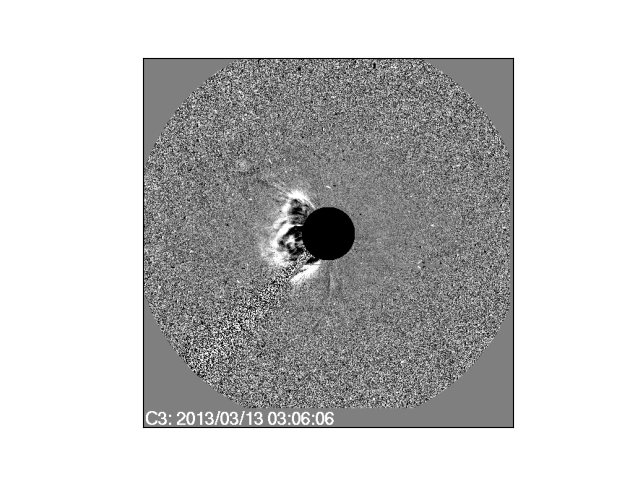  
   卷积层图像：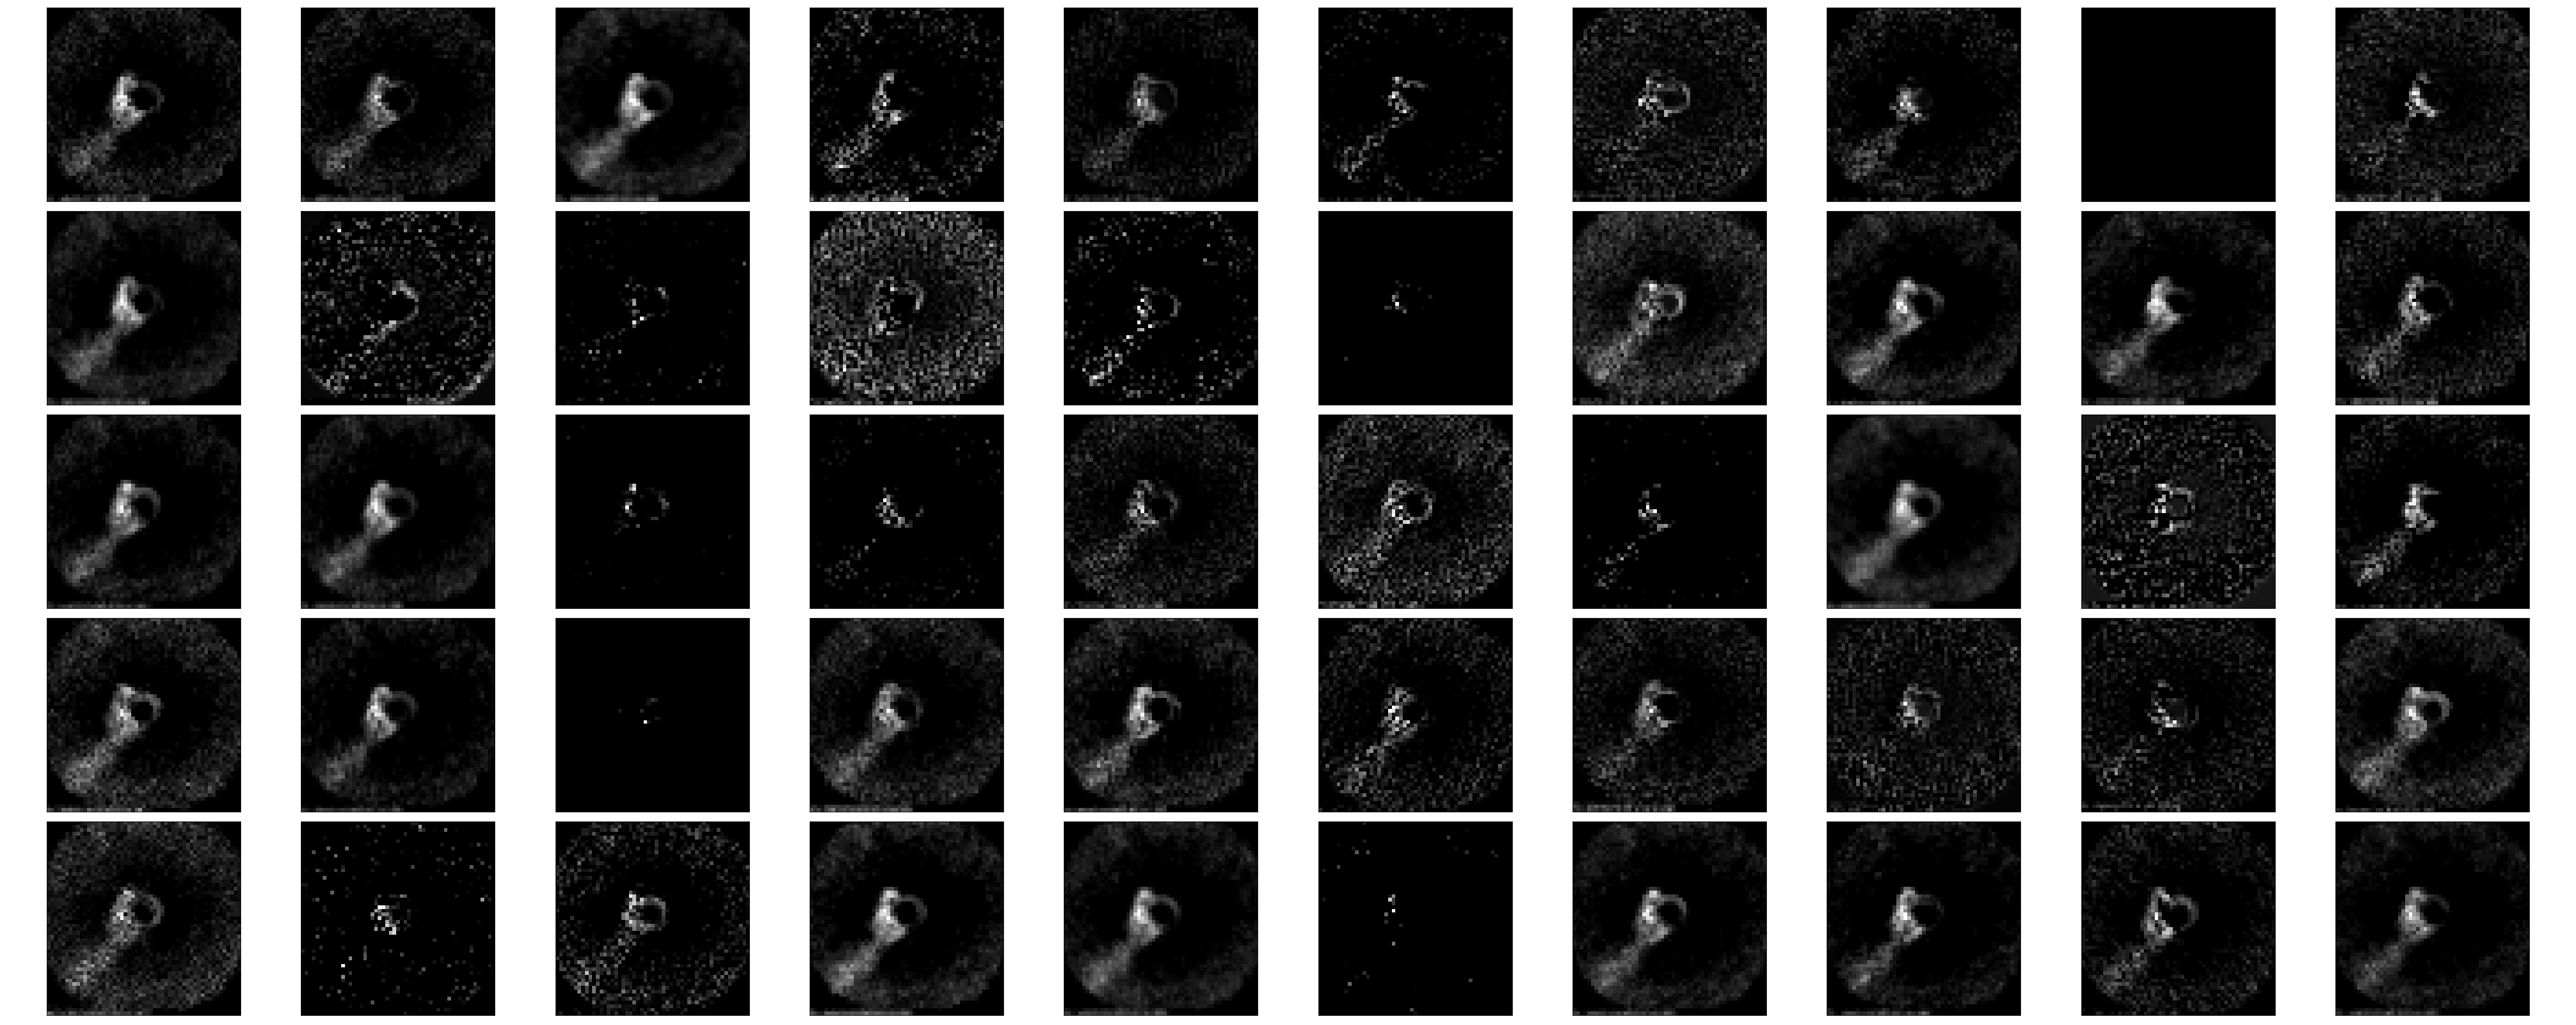
   - 尝试利用插值或者遮挡的方式清除掉支撑杆的影响
1. 极坐标转换应以正北为极轴，逆时针方向转换   &#10004;
2. 尝试获得有关CME偏转的信息
3. 尝试识别STEREO图像数据
4. 利用聚类方法获取角宽度和中央位置角
5. 观察在Robbrecht and Berghmans(2004)以及Byrne et al(2012)中提到的C3日冕仪外侧信噪比过大的问题
6. 类似(Qu et al. 2006)(Olmedo et al. 2008)提到的方法，获得二值分割图后，可以使用形态学方法合并分割的区域，连接被分割的区域，去除噪声
7. 尝试随机减小亮度(来自CAMEL的方法)
8. 使用聚类方法完成共定位图的二值化，设想可以应对多个CME同时出现的情况，值越大的像素约可能是某个CME的中心，这样形成多个聚类中心，也就是多个CME



### 轮廓线合并

In [ ]:
# 将轮廓线合为一个整体
class ConnectedContour(Contour):
    '''用以描述被视为一个整体的两个原本分开的轮廓线
    '''
    def __init__(self, cntA: Contour, cntB: Contour):
        connectedArray = np.concatenate((cntA.array, cntB.array), axis=0)
        if cntA.binaryProjectMapIndex != cntB.binaryProjectMapIndex:
            raise ValueError(
                'Contours connected should be in the SAME binary map')
        xa, ya, wa, ha = cv2.boundingRect(cntA.array)
        xb, yb, wb, hb = cv2.boundingRect(cntB.array)
        # 要求组合为整体的两个轮廓线必须是被极坐标转换而分开的
        # 这要求左侧的轮廓线最左侧坐标为0，右侧轮廓线最右侧坐标为360
        if (xa != 0 or xb + wb != 360) and (xb != 0 and xa + wa != 360):
            raise ValueError(
                'Contours are not seprated by polar transformation,xa,wa,xb,wb={},{},{},{}'
                .format(xa, wa, xb, wb))
        super().__init__(connectedArray, cntA.binaryProjectMap,
                         cntA.contourIndex, cntA.binaryProjectMapIndex)
        self._cntA = cntA
        self._cntB = cntB

    def getPositionalAngel(self) -> List:
        '''返回组合轮廓线的位置角,返回值为[0,a,b,359]的形式

        Parameters
        ----------
        isWarpToNorth : bool
            若为True，则将角度转化为以图像北侧为0度，逆时针方式测量的值

        Returns
        -------
        np.ndarray
            由两个子轮廓线左侧和右侧位置角构成的数组，分别为
            [0,cntARight,cntBLeft,359]
        '''
        cntAPA = self._cntA.getPositionalAngel()
        cntBPA = self._cntB.getPositionalAngel()
        if 0 in cntAPA:
            PA = cntAPA + cntBPA
        else:
            PA = cntBPA + cntAPA

        return PA

    def getCentralPositionAngel(self) -> float:
        '''获取CME轮廓线中央位置角度

        Parameters
        ----------
        isWarpToNorth : bool
            若为True，则将角度转化为以图像北侧为0度，逆时针方式测量的值

        Returns
        -------
        float
            该CME轮廓线的中央位置角
        '''
        cntARight = self.getPositionalAngel()[1]
        cntBLeft = self.getPositionalAngel()[2]
        CPA = int(((cntARight + cntBLeft) / 2 + 180) % 360)
        return CPA

    def getAngularWidth(self) -> int:
        '''返回角宽度

        Returns
        -------
        int
            角宽度
        '''
        cntARight = self.getPositionalAngel()[1]
        cntBLeft = self.getPositionalAngel()[2]
        return 360 - cntBLeft + cntARight


### 过滤轮廓线识别结果

In [ ]:
# 过滤日冕仪识别结果
def filterCoronagraphResultList(coronagraphResults: List[CoronagraphResult]):
    filtedInd = []
    for i in range(1, len(coronagraphResults) - 1):
        # 若连续两个识别高度都小于前一个，则从该识别结果开始后的每一个都需要去掉
        if coronagraphResults[i].height < coronagraphResults[
                i - 1].height and coronagraphResults[
                    i + 1].height < coronagraphResults[i - 1].height:
            filtedInd.extend(list(range(i, len(coronagraphResults))))
        # 若某一个识别高度小于前后两个，则该识别结果需要去掉
        if coronagraphResults[i].height < coronagraphResults[
                i - 1].height and coronagraphResults[
                    i + 1].height > coronagraphResults[i].height:
            filtedInd.append(i)
    filteredResults = [
        result for i, result in enumerate(coronagraphResults)
        if i not in filtedInd
    ]
    return filteredResults


### 轮廓线识别噪声

In [ ]:
class FeatureVisualization:
    '''对神经网络最后一层的特征图进行展示
    '''
    def __init__(self, model: torch.nn.Module, data: np.ndarray) -> None:
        self.model = model
        self.data = data
        self.featureMap = DDT.getActivation(self.model,
                                            self.data).transpose(0, 3, 1, 2)

    def display(self, imageIndex: int):
        '''对神经网络特征图最后一层进行展示

        Parameters
        ----------
        imageIndex : int
            需要展示特征图的图片的索引
        '''
        from math import ceil
        cols = 10
        nums = self.featureMap[imageIndex].shape[0]
        rows = ceil(nums / cols)

        plt.figure()
        plt.imshow(self.data[imageIndex, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.figure(figsize=(cols * 5, rows * 5))
        ind = 0
        for i in range(rows):
            for j in range(cols):
                ax = plt.subplot(rows, cols, ind + 1)
                feature = self.featureMap[imageIndex, ind]
                feature = (feature - np.amin(feature)) / (
                    np.amax(feature) - np.amin(feature) + 1e-5)
                feature = np.round(feature * 255)
                ax.imshow(feature, cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])
                ind += 1
                if ind >= nums:
                    break
        plt.tight_layout()
        plt.show()


In [ ]:
# 测试C3日冕仪图像共定位图掩星盘附近的圆环是否是由于用无blur的网络识别blur的图片引起
import torchvision

netC3NoBlur = model.model_defination.LeNet5(size=224)
netC3NoBlur.load_param(r'trainIssueLog\2023_03_11_00_08_56\parameters.pkl')
netC3Blur = model.model_defination.LeNet5(size=224)
netC3Blur.load_param(r'trainIssueLog\2023_03_10_21_33_14_blur\parameters.pkl')
transform = torchvision.transforms.Compose(
    [divide255,
     utils.CenterCrop('NCHW', circlePoint=(244, 256), radius=37)])
c3arrayblur = box_blur(
    torch.from_numpy(
        utils.loadImageFolder(imagePath, transform=transform, regex='c3')),
    (3, 3)).numpy()
c3arraynoblur = utils.loadImageFolder(imagePath,
                                      transform=transform,
                                      regex='c3')
ind = 8
featureVisul = FeatureVisualization(netC3Blur, c3arraynoblur)
featureVisul.display(ind)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(DDT.DDTThirdParty(c3arraynoblur, netC3Blur)[ind].squeeze(),
           cmap='gray')
plt.show()


In [ ]:
# 增加数据集前后训练的网络对于挡杆的效果对比
ind = 8
featureVisul = FeatureVisualization(netC3, imageArrayC3)
featureVisul.display(ind)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(projectedMapC3[ind].squeeze(), cmap='gray')
plt.show()

tC3 = model.model_defination.LeNet5(size=224)
tC3.load_param(r'trainIssueLog\2023_02_14_15_58_32\parameters.pkl')
featureVisul = FeatureVisualization(tC3, imageArrayC3)
featureVisul.display(ind)
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(DDT.DDTThirdParty(imageArrayC3, tC3)[ind].squeeze(), cmap='gray')
plt.show()

In [ ]:
rightInd = 10
leftInd = rightInd + 1
plt.imshow(np.abs(imageArrayC3[rightInd] - imageArrayC3[leftInd]).squeeze(),
           cmap='gray')
plt.show()

### 极坐标转换极轴位置

In [ ]:
def _linear_polar_mapping(output_coords, k_angle, k_radius, center):
    """从欧几里得坐标系转换为极坐标系的反向坐标变换函数  
    
    为自行修改的版本，是以图像北侧为极轴，逆时针测量的变换。配合skimage.transform.warp使用
    skimage.transform中原本的函数是以图像东侧为极轴，顺时针测量。
    """
    angle = output_coords[:, 1] / k_angle
    rr = ((output_coords[:, 0] / k_radius) * -np.cos(angle)) + center[0]
    cc = ((output_coords[:, 0] / k_radius) * -np.sin(angle)) + center[1]
    coords = np.column_stack((cc, rr))
    return coords


def safeAsInt(val, atol=1e-3):
    """
    安全地将值转化为整形

    Parameters
    ----------
    val : scalar or iterable of scalars
        Number or container of numbers which are intended to be interpreted as
        integers, e.g., for indexing purposes, but which may not carry integer
        type.
    atol : float
        Absolute tolerance away from nearest integer to consider values in
        ``val`` functionally integers.

    Returns
    -------
    val_int : NumPy scalar or ndarray of dtype `np.int64`
        Returns the input value(s) coerced to dtype `np.int64` assuming all
        were within ``atol`` of the nearest integer.
    """
    mod = np.asarray(val) % 1  # Extract mantissa

    # Check for and subtract any mod values > 0.5 from 1
    if mod.ndim == 0:  # Scalar input, cannot be indexed
        if mod > 0.5:
            mod = 1 - mod
    else:  # Iterable input, now ndarray
        mod[mod > 0.5] = 1 - mod[mod > 0.5]  # Test on each side of nearest int

    try:
        np.testing.assert_allclose(mod, 0, atol=atol)
    except AssertionError:
        raise ValueError(f'Integer argument required but received '
                         f'{val}, check inputs.')

    return np.round(val).astype(np.int64)


def warpPolar(image: np.ndarray,
              center: Optional[Tuple[float, float]] = None,
              *,
              radius: Optional[int] = None,
              output_shape: Optional[Tuple[int, int]] = None,
              channel_axis=None,
              **kwargs):
    """将图像重新映射至极坐标

    Parameters
    ----------
    image : ndarray
        Input image. Only 2-D arrays are accepted by default. 3-D arrays are
        accepted if a `channel_axis` is specified.
    center : tuple (row, col), optional
        Point in image that represents the center of the transformation (i.e.,
        the origin in cartesian space). Values can be of type `float`.
        If no value is given, the center is assumed to be the center point
        of the image.
    radius : float, optional
        Radius of the circle that bounds the area to be transformed.
    output_shape : tuple (row, col), optional
    multichannel : bool, optional
        Whether the image is a 3-D array in which the third axis is to be
        interpreted as multiple channels. If set to `False` (default), only 2-D
        arrays are accepted. This argument is deprecated: specify
        `channel_axis` instead.
    channel_axis : int or None, optional
        If None, the image is assumed to be a grayscale (single channel) image.
        Otherwise, this parameter indicates which axis of the array corresponds
        to channels.
    **kwargs : keyword arguments
        Passed to `transform.warp`.

    Returns
    -------
    warped : ndarray
        The polar or log-polar warped image.
    """
    multichannel = channel_axis is not None
    if image.ndim != 2 and not multichannel:
        raise ValueError(f'Input array must be 2-dimensional when '
                         f'`channel_axis=None`, got {image.ndim}')

    if image.ndim != 3 and multichannel:
        raise ValueError(f'Input array must be 3-dimensional when '
                         f'`channel_axis` is specified, got {image.ndim}')

    if center is None:
        center = (np.array(image.shape)[:2] / 2) - 0.5

    if radius is None:
        w, h = np.array(image.shape)[:2] / 2
        radius = np.sqrt(w**2 + h**2)

    if output_shape is None:
        height = 360
        width = int(np.ceil(radius))
        output_shape = (height, width)
    else:
        output_shape = safeAsInt(output_shape)
        height = output_shape[0]
        width = output_shape[1]

    k_radius = width / radius
    map_func = _linear_polar_mapping

    k_angle = height / (2 * np.pi)
    warp_args = {'k_angle': k_angle, 'k_radius': k_radius, 'center': center}

    from skimage.transform import warp
    warped = warp(image,
                  map_func,
                  map_args=warp_args,
                  output_shape=output_shape,
                  preserve_range=True,
                  order=0,
                  **kwargs)
    return warped


def warpCartToPolar(img: np.ndarray, dsize: tuple[int, int],
                    center: tuple[int, int], maxRadius: float) -> np.ndarray:
    '''将数组转换为极坐标形式

    坐标变换会改变图像像素值分布

    Parameters
    ----------
    img : np.ndarray
        需要转换的数组，形状为NHW或NHWC
    dsize : tuple
        输出的图像大小，格式为(列,行)
    center : tuple
        转换中心，格式为(列,行)
    maxRadius : float
        最大半径，决定转换的最大范围

    Returns
    -------
    np.ndarray
        转换后的图片数组，类型同输入图像数组img相同
    '''
    # skimage接受的中心坐标和图像尺寸都是(行,列)，需要进行转换
    center = (center[1], center[0])
    dsize = (dsize[1], dsize[0])
    if img.ndim != 3 and img.ndim != 4:
        raise ValueError('Input image shape must be 3 or 4 ,got {}'.format(
            img.ndim))
    if img.ndim == 3:  # 如果img是NHW，则imgInPolar形状为(N,dsize.h,dsize.w)
        imgInPolar = np.zeros((img.shape[0], dsize[0], dsize[1]),
                              dtype=img.dtype)
    else:  # 如果img是NHW，则imgInPolar形状为(N,dsize.h,dsize.w,C)
        imgInPolar = np.zeros((img.shape[0], dsize[0], dsize[1], img.shape[3]),
                              dtype=img.dtype)
    channel_axis = None if img.ndim == 3 else 3
    from skimage.transform import rotate
    for i in range(img.shape[0]):
        imgPol = warpPolar(img[i],
                           center,
                           radius=maxRadius,
                           output_shape=dsize,
                           channel_axis=channel_axis)
        imgPol = rotate(imgPol, 90, order=0, preserve_range=True)
        # imgPol = cv2.warpPolar(img[i], dsize, center, maxRadius,
        #                        cv2.INTER_NEAREST + cv2.WARP_POLAR_LINEAR)
        # imgPol = cv2.rotate(imgPol, cv2.ROTATE_90_COUNTERCLOCKWISE)
        imgInPolar[i] = imgPol
    return imgInPolar

In [ ]:
import skimage

w = warpPolar(imageArray[3].squeeze(), (243, 258),
              radius=245,
              output_shape=(360, 360))
w = skimage.transform.rotate(w, 90)
plt.imshow(w, cmap='gray')


### 形态学方法连接区域  
形态学闭运算就是先进行膨胀，再进行腐蚀，可用于消除前景物体内部的空洞，或者是前景物体内部的噪声，连接分隔的前景。  
形态学开运算先进行腐蚀，再进行膨胀，消除前景纤细的物体，分离物体，平滑物体边界。

In [ ]:
import cv2

image = otsuBinaryMapC3[16]
image = (image / 255).astype('uint8')
print(image.max(), image.dtype)
kernel = np.ones(20, np.uint8)
opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(25, 5))
plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title('original')
plt.subplot(1, 5, 2)
plt.imshow(opened, cmap='gray')
plt.title('opened')
plt.subplot(1, 5, 3)
plt.title('closed')
plt.imshow(closed, cmap='gray')
openclose = cv2.morphologyEx(cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel),
                             cv2.MORPH_CLOSE, kernel)
closeopen = cv2.morphologyEx(cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel),
                             cv2.MORPH_OPEN, kernel)
plt.subplot(1, 5, 4)
plt.imshow(openclose, cmap='gray')
plt.title('open and close')
plt.subplot(1, 5, 5)
plt.imshow(closeopen, cmap='gray')
plt.title('close and open')
plt.show()


In [ ]:
def morphologyOperation(images: np.ndarray, operation: int,
                        kernelSize: int) -> np.ndarray:
    '''对输入二值图像进行单次形态学操作

    Parameters
    ----------
    images : np.ndarray
        需要进行操作的数组,形状为NHW,类型为uint8
    operation : int
        需要进行的操作对应的序号
        对应关系如下：
            cv::MORPH_ERODE    = 0,
            cv::MORPH_DILATE   = 1,
            cv::MORPH_OPEN     = 2,
            cv::MORPH_CLOSE    = 3,
            cv::MORPH_GRADIENT = 4,
            cv::MORPH_TOPHAT   = 5,
            cv::MORPH_BLACKHAT = 6,
            cv::MORPH_HITMISS  = 7
    kernelSize : int
        形态学操作的核大小（默认为矩形核）

    Returns
    -------
    np.ndarray
        完成变换的数组，形状与输入数组相同
    '''
    kernel = np.ones(kernelSize, np.uint8)
    morphImages = np.zeros_like(images)
    for i in range(images.shape[0]):
        morphImages[i] = cv2.morphologyEx(images[i], operation, kernel)
    return morphImages


def morphologyOperations(images: np.ndarray, operations: List[int],
                         kernelSize: int) -> np.ndarray:
    '''对输入二值图像进行多次形态学操作

    Parameters
    ----------
    images : np.ndarray
        需要进行操作的数组,形状为NHW,类型为uint8
    operations : List[int]
        需要进行的操作对应的序号构成的列表，将按照列表顺序依次进行形态学操作。
        对应关系如下：
            cv::MORPH_ERODE    = 0,
            cv::MORPH_DILATE   = 1,
            cv::MORPH_OPEN     = 2,
            cv::MORPH_CLOSE    = 3,
            cv::MORPH_GRADIENT = 4,
            cv::MORPH_TOPHAT   = 5,
            cv::MORPH_BLACKHAT = 6,
            cv::MORPH_HITMISS  = 7
    kernelSize : int
        形态学操作的核大小（默认为矩形核）

    Returns
    -------
    np.ndarray
        完成变换的数组，形状和类型与输入数组相同
    '''
    for operation in operations:
        images = morphologyOperation(images, operation, kernelSize)
    return images


### 尝试用插值填充挡杆位置

In [ ]:
def interpolatePylon(arr):
    from scipy.interpolate import griddata
    arr = arr.copy()
    maskArr = np.array(
        Image.open(r'C:\Programing\CMEclassfication\CME_data\遮挡右上角支撑架扩大.png').
        convert('L'))
    knownPoints = np.argwhere(maskArr > 0)
    values = arr[knownPoints[:, 0], knownPoints[:, 1]]
    xi = np.argwhere(maskArr == 0)
    gridedVals = griddata(knownPoints, values, xi, method='cubic')
    arr[xi[:, 0], xi[:, 1]] = gridedVals
    return arr

In [ ]:
# interpolated=np.zeros_like(imageArrayC3)
# for i in range(imageArrayC3.shape[0]):
#     interpolated[i]=interpolatePylon(imageArrayC3[i].squeeze())


### 随机增减亮度提高训练效果

In [ ]:
import torchvision

jitter = torchvision.transforms.ColorJitter(brightness=(0.2, 0.9))
trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    jitter,
    # utils.ToTensorNoDiv255(),
    # 遮挡C3的圆盘所需的参数设置circlePoint=(244, 256), radius=37
    # BoxBlur((3, 3)) BoxBlur仅支持NCHW 因此移动到读取X时才进行BoxBlur
])
''.join(str(trans).split())

In [ ]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T

plt.rcParams["savefig.bbox"] = 'tight'

orig_img = Image.open(
    r'CME_data\LascoC2C3\20080122\20080123_061804_lasc3rdf.png').convert('RGB')
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]
    plt.figure(figsize=(4 * 5, 5))
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows,
                            ncols=num_cols,
                            squeeze=False,
                            figsize=(20, 5))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs, cmap='gray')
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


jitter = T.ColorJitter(brightness=(0.2, 0.9))
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

In [ ]:
plt.imshow(projectedMapC3[2].squeeze(),cmap='gray')

In [ ]:
import time as time

import numpy as np
from distutils.version import LooseVersion
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt

import skimage
from skimage.data import coins
from skimage.transform import rescale

from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering


def modiDDTThirdParty(imgs: np.ndarray, net: torch.nn.Module):
    '''对imgs进行DDT算法，返回经过投影变换后的特征图

    Parameters
    ----------
    imgs : np.ndarray
        需要进行变换的图像，形状为NCHW
    net : torch.nn.Module
        使用的CNN网络

    Returns
    -------
    np.ndarray
        经过投影变换后的特征图，形状为NCHW
    '''
    import DDT
    import utils
    import torch
    features = torch.from_numpy(DDT.getActivation(net, imgs))
    features = utils.NHWCtoNCHW(features)  # pca的输入应当为HCHW
    project_map = torch.clamp(DDT.pca(features), min=0)
    maxv = project_map.view(project_map.size(0),
                            -1).max(dim=1)[0].unsqueeze(1).unsqueeze(1)
    project_map /= maxv

    return project_map


projectedMapC3 = modiDDTThirdParty(imageArrayC3, netC3)

# these were introduced in skimage-0.14
if LooseVersion(skimage.__version__) >= '0.14':
    rescale_params = {'anti_aliasing': False, 'multichannel': False}
else:
    rescale_params = {}

# #############################################################################
# Generate data
orig_coins = coins()

# Resize it to 20% of the original size to speed up the processing
# Applying a Gaussian filter for smoothing prior to down-scaling
# reduces aliasing artifacts.
smoothened_coins = gaussian_filter(orig_coins, sigma=2)
# rescaled_coins = rescale(smoothened_coins,
#                          0.2,
#                          mode="reflect",
#                          **rescale_params)
rescaled_coins = projectedMapC3[3].squeeze()
X = np.reshape(rescaled_coins, (-1, 1))

# #############################################################################
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*rescaled_coins.shape)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 2  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters,
                               linkage='ward',
                               connectivity=connectivity)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

# #############################################################################
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l,
                colors=[
                    plt.cm.nipy_spectral(l / float(n_clusters)),
                ])
plt.xticks(())
plt.yticks(())
plt.show()

### 聚类方法完成共定位图二值化

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750,
                            centers=centers,
                            cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" %
      metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" %
      metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0],
             xy[:, 1],
             'o',
             markerfacecolor=tuple(col),
             markeredgecolor='k',
             markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0],
             xy[:, 1],
             'o',
             markerfacecolor=tuple(col),
             markeredgecolor='k',
             markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)

In [ ]:
X = projectedMapC3[2].squeeze().numpy().reshape(-1, 1)
clustering = AffinityPropagation(random_state=5).fit(X)
clustering.labels_

In [ ]:
clustering.cluster_centers_.shape